In [3]:
from neo import Spike2IO

import numpy as np
import scipy 
import h5py
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from pathlib import Path
import pandas as pd
import seaborn as sns
import seaborn.distributions as sd
from seaborn.palettes import color_palette, blend_palette, dark_palette, light_palette
import statsmodels.api as sm

%matplotlib inline

In [72]:
def get_range_bounds(win_times,trigger):
    start = np.min(np.where(trigger>win_times[0])[0])
    stop= np.max(np.where(trigger<win_times[1])[0])
    trials = list(range(start,stop))
    return trials
    
def TrialEventTimes(trigger,analevent,trial,win):
    t1 = trigger[trial]
    t2 = t1+win
    EventTimes = analevent[np.where((analevent>t1)&(analevent<t2))]-t1
    return(EventTimes)
    
def CostFunction(y_hist, N, w, dt):
    """
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "Kernel Bandwidth Optimization in 
           Spike Rate Estimation," in Journal of Computational Neuroscience 
           29(1-2): 171–182, 2010 http://dx.doi.org/10.1007/s10827-009-0180-4
    """
    #spike density function optimization 
    # build normal smoothing kernel
    yh = fftkernel(y_hist, w / dt)

    # formula for density
    C = np.sum(yh**2) * dt - 2 * np.sum(yh * y_hist) * dt + 2 \
        / (2 * np.pi)**0.5 / w / N
    C = C * N**2

    return C, yh

def fftkernel(x, w):
    """
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "Kernel Bandwidth Optimization in 
           Spike Rate Estimation," in Journal of Computational Neuroscience 
           29(1-2): 171–182, 2010 http://dx.doi.org/10.1007/s10827-009-0180-4
    """

    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))

    X = np.fft.fft(x, n.astype(np.int))

    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: np.int(n / 2 + 1)],
                        f[1: np.int(n / 2 - 1 + 1)][::-1]))

    K = np.exp(-0.5 * (w * 2 * np.pi * f) ** 2)

    y = np.real(np.fft.ifft(X * K, n))

    y = y[0:L]

    return y

def sskernel(x, tin, W):
    """
    Generates a kernel density estimate with globally-optimized bandwidth.
    The optimal bandwidth is obtained as a minimizer of the formula, sum_{i,j}
    \int k(x - x_i) k(x - x_j) dx  -  2 sum_{i~=j} k(x_i - x_j), where k(x) is
    the kernel function.
    Parameters
    ----------
    x : array_like
        The one-dimensional samples drawn from the underlying density
    tin : array_like
        The values where the density estimate is to be evaluated in generating
        the output 'y'.
    W : array_like
        The kernel bandwidths to use in optimization. Should not be chosen
        smaller than the sampling resolution of 'x'.

    Returns
    -------
    y : array_like
        The estimated density, evaluated at points t / tin.
    t : array_like
        The points where the density estimate 'y' is evaluated.
    optw : double
        The optimal global kernel bandwidth.
    C : array_like
        The cost functions associated with the bandwidths 'W'.

    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "Kernel Bandwidth Optimization in 
           Spike Rate Estimation," in Journal of Computational Neuroscience 
           29(1-2): 171–182, 2010 http://dx.doi.org/10.1007/s10827-009-0180-4
    """

    # set argument 't' if not provided
    #always provide xtime input so that output is aligned to trial duration
    T = np.max(x) - np.min(x)
    x_ab = x[(x >= np.min(tin)) & (x <= np.max(tin))]
    dx = np.sort(np.diff(np.sort(x)))
    dt_samp = dx[np.nonzero(dx)][0]
    if dt_samp > np.min(np.diff(tin)):
        t = np.linspace(np.min(tin), np.max(tin), np.min([int(np.ceil(T / dt_samp)), int(1e3)]))
    else:
        t = tin

    # calculate delta t
    dt = min(np.diff(t))

    # create the finest histogram
    thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
    y_hist = np.histogram(x_ab, thist-dt/2)[0]
    N = sum(y_hist).astype(np.float)
    y_hist = y_hist / N / dt

    # always provide W
    C = np.zeros((1, len(W)))[0]
    C_min = np.Inf
    ymat=[]
    for k, w in enumerate(W):
        C[k], yh = CostFunction(y_hist, N, w, dt)
        ymat.append(yh)
        if((C[k] < C_min).any()):
            C_min = C[k]
            optw = w
            y = yh
    ymat = np.asarray(ymat)       
    
    return y, t, optw, C, C_min

def spiketimes_align(trigger_times,data_times,trigger,trial_duration):
    aligned_times = []
    for t in trigger_times:
        thesetimes = data_times[
          np.where((data_times>(trigger[t]))&(data_times<(trigger[t]+trial_duration)))[0]
          ]-(trigger[t])
        aligned_times = np.concatenate((aligned_times,thesetimes)) 

    return np.asarray(aligned_times)

def get_optw(these_trials,spikes,xtime,trigger,trial_duration):
    W=np.arange(0.0065,0.3,0.0005)
    aligned_times = spiketimes_align(these_trials,spikes,trigger,trial_duration)
    y, t, optw, C, C_min = sskernel(aligned_times, xtime, W)
    
    return y, t, optw, C, C_min

def get_response_hist(trigger_times,data_times,binw,trigger,trial_duration):
    #binw in seconds
    aligned_times = spiketimes_align(trigger_times,data_times,trigger,trial_duration)
    nbins = np.trunc(trial_duration/binw) #only look at full bins or else last bin would underestimate rate
    r = np.histogram(aligned_times,np.linspace(0,nbins*binw,nbins+1))
    yh = r[0]/len(trigger_times)/binw
    xc = r[1]-np.mean(np.diff(r[1]))
    xc = xc[1:] # [0:len(yh)]
    
    return yh, xc

def get_response(trigger_times,data_func,trial_duration,tau):
    response = [data_func(np.linspace(t,t+trial_duration,int(trial_duration/dt))) for t in trigger_times]
    return np.asarray(response)
    """
    Creates a spike density function from a spike train to do continuous analysis with (such as trial correlations)
    """ 

def filtered_response(spk_times, tau):
    """
    Creates a function with a gaussian centered at every spike time (the mean) with standard deviation tau
    normalized by tau to estimate spike rate
    """
    spk_times = spk_times.reshape((-1, 1))
    norm_factor = tau * np.sqrt(2. * np.pi)
    
    return lambda t: np.sum(np.exp(-(spk_times - t.reshape((1, -1))) ** 2 / (2 * tau * tau)), 0) / norm_factor
    

def _kde_support(data, bw, gridsize, cut, clip):
    """Establish support for a kernel density estimate."""
    support_min = max(data.min() - bw * cut, clip[0])
    support_max = min(data.max() + bw * cut, clip[1])
    return np.linspace(support_min, support_max, gridsize)

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [5]:
path_to_file = Path.cwd()
file_to_open = path_to_file / 'DataMat.csv'
datamat = pd.read_csv(file_to_open)
datamat = datamat.loc[:, ~datamat.columns.str.contains('^Unnamed')]

In [4]:
# afferent_proprio=['20070718_598_coupled_SPK.mat',
#                        '20070719_91_coupled_SPK.mat',
#                        '20070723_287_SPK.mat',
#                        '20070723_311_SPK.mat',
#                        '20070723_339_SPK.mat',
#                        '20070723_415_SPK.mat'
#                        ]
# df_aff_proprio = datamat[datamat['exptname'].isin(afferent_proprio)]#.assign(what='aff_proprio',cell='afferent')

# afferent_free=['20180407_freerun2_SPK.mat',
#                     '20180407_freerun3_SPK.mat',
#                     '20180407_freerun4_SPK.mat',
#                     '20180407_freerun5_SPK.mat'
#                     ]
# df_aff_free = datamat[datamat['exptname'].isin(afferent_free)]#.assign(what='aff_free',cell='afferent')

# aen_vent=['20050727_3224_SPK.mat',
#                '20050728_3404_latency2_SPK.mat',
#                '20050808_3629_latency2_SPK.mat',
#                '20050811_3221_SPK.mat',
#                '20050818_2874_SPK.mat',
#                '20050819_2601_SPK.mat',
#                '20050820_2960_trial1_SPK.mat',
#                '20050824_2627_trial1_SPK.mat',
#                '20060626_2815_SPK.mat',
#                '20060627_2673_SPK.mat',
#                '20060708_3004_SPK.mat',
#                '20060710_2767_SPK.mat',
#                '20060710_3196_SPK.mat',
#                '20060804_2107_SPK.mat',
#                '20060812_2921_SPK.mat',
#                '20060812_3066_SPK.mat',
#                '20060812_3205_SPK.mat',
#                '20060816_3893_SPK.mat',
#                '20071025_3335_SPK.mat',
#                '20071026_3108_SPK.mat',
#               ]
# df_aen_vent = datamat[datamat['exptname'].isin(aen_vent)]#.assign(what='aen_vent',cell='aen')

# aen_proprio=['20070816_3375_SPK.mat',
#                '20070816_3509_SPK.mat',
#                '20070720_3352_SPK.mat',
#                '20070727_3798_SPK.mat',,
#                '20070808_3727_SPK.mat'
#                '20070816_3838_SPK.mat'
#               ]
# df_aen_proprio = datamat[datamat['exptname'].isin(aen_proprio)]#.assign(what='aen_proprio',cell='aen')

# aen_ventcmd=['20170810_expt4_vent_SPK.mat',
#                '20170810_expt5_vent_SPK.mat',
#                '20170815_expt8_vent_SPK.mat',
#                '20170815_expt9_vent_SPK.mat'
#               ]
# df_aen_ventcmd = datamat[datamat['exptname'].isin(aen_ventcmd)]#.assign(what='aen_ventcmd',cell='aen')

# aen_swimcmd=['20180124_expt1_swim_SPK.mat',
#                 '20180124_expt2_swim_SPK.mat',
#                 '20170815_expt10_swim_SPK.mat'
#               ]
# df_aen_swimcmd = datamat[datamat['exptname'].isin(aen_swimcmd)]#.assign(what='aen_swimcmd',cell='aen')

# aen_test = ['20050824_2627_trial1_SPK.mat',
#                  '20070727_3798_SPK.mat',
#                  '20071025_3335_SPK.mat',
#                  '20071026_3108_SPK.mat',
#                 '20070801_3838_SPK.mat'
#                 ]
# df_aen_test = datamat[datamat['exptname'].isin(aen_test)]#.assign(what='aen_test',cell='aen')

# aen_control = ['20050824_2627_control_SPK.mat',
#                  '20070727_3798_control_SPK.mat',
#                  '20071025_3335_control_SPK.mat',
#                  '20071026_3108_control_SPK.mat',
#                 '20070801_3838_control_SPK.mat'
#                 ]
# df_aen_control = datamat[datamat['exptname'].isin(aen_control)]#.assign(what='aen_control',cell='aen')

# aen_latency1 = ['20050728_3404_latency1_SPK.mat',
#                  '20050808_3629_latency1_SPK.mat'
#                 ]
# df_aen_latency1 = datamat[datamat['exptname'].isin(aen_latency1)]#.assign(what='aen_latency1',cell='aen')

# aen_latency2 = ['20050728_3404_latency2_SPK.mat',
#                  '20050808_3629_latency2_SPK.mat'
#                 ]
# df_aen_latency2 = datamat[datamat['exptname'].isin(aen_latency2)]#.assign(what='aen_latency2',cell='aen')


In [6]:
######## add columns for calculated changes in spike rate relative to prestimulus rates
alldf = datamat
alldf['spkrt_change_stimi_base'] = alldf['spkrt_stimi']-alldf['spkrt_base']
alldf['spkrt_change_stimf_base'] = alldf['spkrt_stimf']-alldf['spkrt_base']
alldf['spkrt_change_stimf_stimi'] = alldf['spkrt_stimf']-alldf['spkrt_stimi']
alldf['spkrt_change_post_base'] = alldf['spkrt_post']-alldf['spkrt_base']
alldf['spkrt_change_recover_base'] = alldf['spkrt_recovery']-alldf['spkrt_base']
alldf['spkrt_change_post_recover'] = alldf['spkrt_recovery']-alldf['spkrt_post']
alldf['sp_change'] = alldf['sp_poststim_mean']- alldf['sp_basestim_mean']
alldf['sp_change_recover'] = alldf['sp_recoverstim_mean']- alldf['sp_basestim_mean']

alldf = alldf[alldf.exptname!='20180407_freerun2_SPK.mat']
    #this afferent does not seem modulated by stimulus; 
    #include only afferents that were modulated by mechanosensory stimuli as per Methods

In revised manuscipt excluding motor command experimental conditions because sample size too small to stand alone and to determine if can be grouped with other conditions or not.

In [7]:
alldf = alldf[(alldf.condition!='aen_swimcmd')&(alldf.condition!='aen_ventcmd')]

Throughout each experiment in the paired condition, trial onset was triggered by one of two signals associated with ventilation or swimming movements (Fig. 2B; as described in Methods). Based on previous literature in the electrosensory system, proprioceptive signals and motor commands associated with both ventilation and proprioceptive signals and sensory feedback signals associated with fin movements are expected to provide a basis for the generation of cancellation signals (Schmidt and Bodznick, 1987; Montgomery et al. 1996; ref from DON? refs). The results obtained under these two conditions were statistically not significant from each other and have been combined for all analyses (an example cell from each condition is shown in Fig. 3A&B). <br/>
STATS as follows for main results of study (1) changes in poststimulus spike rate and (2) correlation to stimulus: 

In [9]:
sr_v = alldf[(alldf['condition']=='aen_vent')&(alldf['phase']=='phase1')&(alldf['trigger_type']=='paired')]['spkrt_change_post_base'].values
sr_fl = alldf[(alldf['condition']=='aen_proprio')&(alldf['phase']=='phase1')&(alldf['trigger_type']=='paired')]['spkrt_change_post_base'].values
r = stats.mannwhitneyu(sr_v,sr_fl)
print('(1)')
print(r)

sp_v = alldf[(alldf['condition']=='aen_vent')&(alldf['phase']=='phase1')&(alldf['trigger_type']=='paired')]['sp_change'].values
sp_fl = alldf[(alldf['condition']=='aen_proprio')&(alldf['phase']=='phase1')&(alldf['trigger_type']=='paired')]['sp_change'].values
r = stats.mannwhitneyu(sp_v,sp_fl)
print('(2)')
print(r)

(1)
MannwhitneyuResult(statistic=56.0, pvalue=0.35231137054800765)
(2)
MannwhitneyuResult(statistic=56.0, pvalue=0.35231137054800765)


**some notes on effect sizes and power for results**

In [98]:
print('difference in correlation between the prestimulus:stimulus response and the poststimulus:stimulus response')
d1 = alldf[(alldf['cell']=='aen')&(alldf['phase']=='phase1')&(alldf['trigger_type']=='paired')]['sp_poststim_mean'].values
d2 = alldf[(alldf['cell']=='aen')&(alldf['phase']=='phase1')&(alldf['trigger_type']=='paired')]['sp_basestim_mean'].values
es = cohend(d1, d2)
print('effect size = ' + str(es))

display(alldf[(alldf['cell']=='aen')&(alldf['phase']=='phase1')&(alldf['trigger_type']=='paired')][['sp_poststim_mean','sp_basestim_mean']].describe())

print(' ')
print('difference in spike rate between the prestimulus and the poststimulus response')
d1 = alldf[(alldf['cell']=='aen')&(alldf['phase']=='phase1')&(alldf['trigger_type']=='paired')]['spkrt_post'].values
d2 = alldf[(alldf['cell']=='aen')&(alldf['phase']=='phase1')&(alldf['trigger_type']=='paired')]['spkrt_base'].values
es = cohend(d1, d2)
print('effect size = ' + str(es))

difference in correlation between the prestimulus:stimulus response and the poststimulus:stimulus response
effect size = -0.6679196441256972


sp_poststim_mean  sp_basestim_mean
count         27.000000         27.000000
mean          -0.196477          0.033320
std            0.344114          0.343983
min           -0.711848         -0.728269
25%           -0.463366         -0.187173
50%           -0.214484          0.108765
75%           -0.001742          0.245227
max            0.772056          0.495683

 
difference in spike rate between the prestimulus and the poststimulus response
effect size = -0.15313514756894434


In [96]:
from statsmodels.stats.power import TTestIndPower

thistest = TTestIndPower()
r = thistest.solve_power(effect_size=0.67, nobs1=27, alpha=0.05, power=None, ratio=1.0, alternative='two-sided')

print('given above calculated effect size, power for change in response correlation to stimulus in poststimulus period:')
print(r)
print('note that effect size calculation is for independent groups study design,')
print(' whereas within-group implemented here throughout')

given above calculated effect size, power for change in response correlation to stimulus in poststimulus period:
0.6758489856771918
note that effect size calculation is for independent groups study design,
 whereas within-group implemented here throughout


**Relevant background information about how many trials for each analysis period across population** <br/> see Methods

In [14]:
display(alldf[alldf['trigger_type']=='paired']['ntrials_pairing'].describe())

count      39.000000
mean      332.769231
std       258.795028
min        91.000000
25%       186.000000
50%       219.000000
75%       394.500000
max      1051.000000
Name: ntrials_pairing, dtype: float64

In [16]:
alldf[alldf['ntrials_base']<75].exptname

17            20060812_2921_SPK.mat
22      20070719_91_coupled_SPK.mat
24             20070723_287_SPK.mat
25             20070723_311_SPK.mat
26             20070723_339_SPK.mat
27             20070723_415_SPK.mat
30            20070816_3375_SPK.mat
31            20070816_3509_SPK.mat
49            20070801_3838_SPK.mat
50    20070801_3838_control_SPK.mat
Name: exptname, dtype: object

In [74]:
alldf[alldf['ntrials_pairing']<150].exptname

10     20050824_2627_trial1_SPK.mat
18            20060812_3066_SPK.mat
24             20070723_287_SPK.mat
25             20070723_311_SPK.mat
26             20070723_339_SPK.mat
27             20070723_415_SPK.mat
33    20071025_3335_control_SPK.mat
49            20070801_3838_SPK.mat
Name: exptname, dtype: object

In [71]:
alldf[alldf['ntrials_post']<75].exptname

24             20070723_287_SPK.mat
25             20070723_311_SPK.mat
26             20070723_339_SPK.mat
27             20070723_415_SPK.mat
43        20180407_freerun4_SPK.mat
50    20070801_3838_control_SPK.mat
Name: exptname, dtype: object

**Calculate inter-event interval stats**

--> Each ventilation cyle had a median period of 2.93sec (interquartile range, IQR = 1.96 - 3.62; n=21 paired experiments in 21 AENs). In experiments in which the fin was artificially raised and lowered to mimic swimming movements, the fin lift interval (triggered by an internal clock) was set to a slightly longer duration of 4-6sec to minimize turbulent water disturbance (n = 6 paired experiments in 6 AENs). The speed and amplitude of artificial fin lifts were titrated to avoid excessive modulation of baseline spike rates in AENs, which were 1.8 (1.5 – 2.4) Hz for the 6 AENs in this condition. AEN spike rates were 1.5Hz (1.1 – 2.3; n=21 cells) under the ventilation condition. The difference in baseline firing rates between these two experimental conditions was not significant (Mann Whitney U = 55; p=0.33; n1 = 21 AENs in ventilation condition and n2 = 6 AENs in fin lift condition). 

inter-event interval stats


count      mean       std       min       25%      50%       75%  \
condition                                                                       
aen_proprio    6.0  4.912612  0.636920  4.190760  4.510133  4.74655  5.331148   
aen_vent      21.0  2.933595  1.079997  1.280815  1.955700  2.75513  3.617535   

                 max  
condition             
aen_proprio  5.83447  
aen_vent     5.05126

 
prestimulus spike rates under each condition


count      mean       std       min       25%       50%  \
condition                                                              
aen_proprio    6.0  1.920743  0.657747  1.110465  1.469241  1.840774   
aen_vent      21.0  2.531463  2.229589  0.700000  1.108127  1.544304   

                  75%       max  
condition                        
aen_proprio  2.373432  2.836066  
aen_vent     2.329167  8.865248

MannwhitneyuResult(statistic=55.0, pvalue=0.33090742168694987)


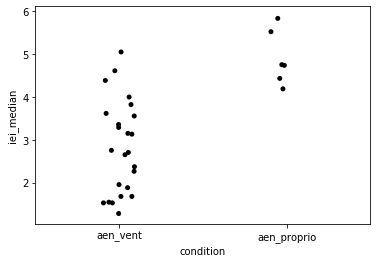

In [25]:
print('inter-event interval stats')
display(alldf[((alldf.cell=='aen')&(alldf.trigger_type=='paired')&(alldf.phase=='phase1'))].
        groupby(['condition'])['iei_median'].describe())
sns.stripplot(x = "condition", y = "iei_median", 
              data = alldf[((alldf.cell=='aen')&(alldf.trigger_type=='paired'))],
             color='black')
print(' ')
print('prestimulus spike rates under each condition')
display(alldf[((alldf.trigger_type=='paired')&
               (alldf.phase=='phase1')&
               ((alldf.condition=='aen_vent')|(alldf.condition=='aen_proprio')))].
        groupby(['condition'])['spkrt_base'].describe())
r = stats.mannwhitneyu(alldf[((alldf.condition=='aen_vent')&
                              (alldf.trigger_type=='paired')&
                              (alldf.phase=='phase1'))]['spkrt_base'].values,
               alldf[((alldf.condition=='aen_proprio')&
                      (alldf.trigger_type=='paired')&
                      (alldf.phase=='phase1'))]['spkrt_base'].values)
print(r)

for AENs:


optw  optw_stim
count  35.000000  35.000000
mean    0.069771   0.024000
std     0.041353   0.016328
min     0.010000   0.006000
25%     0.042000   0.012000
50%     0.060000   0.016000
75%     0.077000   0.037000
max     0.178000   0.064000


for afferents:


optw  optw_stim
count  9.000000   9.000000
mean   0.102889   0.022000
std    0.074412   0.018466
min    0.032000   0.006000
25%    0.042000   0.006000
50%    0.060000   0.018000
75%    0.198000   0.032000
max    0.198000   0.058000

aen

afferent


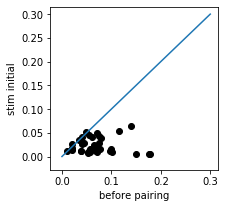

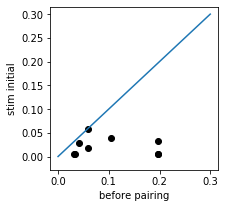

In [75]:
########plot optw between baseline and stimulus period for afferents and aens

print('for AENs:')
display(alldf[(alldf['cell']=='aen')][['optw','optw_stim']].describe())
print('')
print('for afferents:')
display(alldf[(alldf['cell']=='afferent')][['optw','optw_stim']].describe())


########plot optw between baseline and stimulus period for afferents and aens
print('aen')
cell = 'aen'
lims = [-0.01,0.2]
fig= plt.figure(figsize = (3,3))
ax = plt.gca()
data = np.asarray([alldf[alldf.cell==cell]['optw'].values,
                  alldf[alldf.cell==cell]['optw_stim'].values]).T
plt.scatter(data[:,0],data[:,1],color = 'black')
plt.plot([0,0.3],[0,0.3])
plt.xlabel('before pairing')
plt.ylabel('stim initial')
plt.savefig('Figures/revisions/scatter_optwstim_optwbase_' + cell + '.eps', format='eps', dpi=1000)

print('')
print('afferent')
cell = 'afferent'
lims = [-0.01,0.2]
fig= plt.figure(figsize = (3,3))
ax = plt.gca()
data = np.asarray([alldf[alldf.cell==cell]['optw'].values,
                  alldf[alldf.cell==cell]['optw_stim'].values]).T
plt.scatter(data[:,0],data[:,1],color = 'black')
plt.plot([0,0.3],[0,0.3])
plt.xlabel('before pairing')
plt.ylabel('stim initial')
plt.savefig('Figures/revisions/scatter_optwstim_optwbase_' + cell + '.eps', format='eps', dpi=1000)

**check some of the statistical assumptions of tests in the paper: normality and homoscedasticity** 

In [26]:
print('** NORMALITY **')
print('AEN')
print('post vs base spikerate effect in AEN... is the distribution of within cell changes normal?')
r = stats.normaltest(alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['spkrt_post'].values-
                             alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['spkrt_base'].values)
print(r)
print('')
print('stimi vs stimf spikerate effect in AEN... is the distribution of within cell changes normal?')
r = stats.normaltest(alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['spkrt_stimi'].values-
                             alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['spkrt_stimf'].values)
print(r)
print('')
print('baseline spikerate aen normal?')
r = stats.normaltest(alldf[alldf.cell=='aen']['spkrt_base'].values)
print(r)
print('')
print('post vs base correlation with stim effect in AEN... is the distribution of within cell changes normal?')
r = stats.normaltest(alldf[alldf.cell=='aen']['sp_change'].values)
print(r)
print(' ')
print('baseline correlation to stim aen normal?')
r = stats.normaltest(alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['sp_basestim_mean'].values)
print(r)
print('')
print('post-pairing correlation to stim aen normal?')
r = stats.normaltest(alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['sp_poststim_mean'].values)
print(r)
print('')
print('AFFERENT')
print('post vs base spikerate effect in afferent... is the distribution of within cell changes normal?')
r = stats.normaltest(alldf[alldf.cell=='afferent']['spkrt_post'].values-
                     alldf[alldf.cell=='afferent']['spkrt_base'].values)
print(r)
print('')
print('baseline spikerate afferent normal?')
r = stats.normaltest(alldf[alldf.cell=='afferent']['spkrt_base'].values)
print(r)
print('')
print('change pre to post correlation to stim afferent normal?')
r = stats.normaltest(alldf[alldf.cell=='afferent']['sp_change'].values)
print(r)
print('')
print('baseline correlation to stim afferent normal?')
r = stats.normaltest(alldf[alldf.cell=='afferent']['sp_basestim_mean'].values)
print(r)
print('')
print('post-pairing correlation to stim afferent normal?')
r = stats.normaltest(alldf[alldf.cell=='afferent']['sp_poststim_mean'].values)
print(r)
print('')
print('** homoscedasticity **')
print('AEN')
print('aen post and pre spkrate are the distributions homoscedastic')
r = stats.bartlett(alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['spkrt_post'].values,
                     alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['spkrt_base'].values)
print(r)
print('')
print('aen stimi and stimf spkrate are the distributions homoscedastic')
r = stats.bartlett(alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['spkrt_stimi'].values,
                     alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['spkrt_stimf'].values)
print(r)
print('')
print('aen post and pre correlation with stimulus are the distributions homoscedastic')
r = stats.bartlett(alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['sp_poststim_mean'].values,
                     alldf[(alldf.cell=='aen')&
                           (alldf.trigger_type=='paired')]['sp_basestim_mean'].values)
print(r)
print('AFFERENT')
print('')
print('afferent post and pre spkrate are the distributions homoscedastic')
r = stats.bartlett(alldf[alldf.cell == 'afferent']['spkrt_post'],
                   alldf[alldf.cell == 'afferent']['spkrt_base'])
print(r)
print('')
print('afferent stii and stimf spkrate are the distributions homoscedastic')
r = stats.bartlett(alldf[alldf.cell == 'afferent']['spkrt_stimi'],
                   alldf[alldf.cell == 'afferent']['spkrt_stimf'])
print(r)
print('')
print('afferent post and pre correlation with stimulus are the distributions homoscedastic')
r = stats.bartlett(alldf[alldf.cell == 'afferent']['sp_poststim_mean'],
                   alldf[alldf.cell == 'afferent']['sp_basestim_mean'])
print(r)
print('')
print('')

** NORMALITY **
AEN
post vs base spikerate effect in AEN... is the distribution of within cell changes normal?
NormaltestResult(statistic=1.378380834483559, pvalue=0.5019823008204316)

stimi vs stimf spikerate effect in AEN... is the distribution of within cell changes normal?
NormaltestResult(statistic=3.241546535746715, pvalue=0.1977457295282777)

baseline spikerate aen normal?
NormaltestResult(statistic=30.48443222689529, pvalue=2.4009861229121144e-07)

post vs base correlation with stim effect in AEN... is the distribution of within cell changes normal?
NormaltestResult(statistic=0.40488707452256806, pvalue=0.81673259625543)
 
baseline correlation to stim aen normal?
NormaltestResult(statistic=0.8895302869147168, pvalue=0.6409747954807752)

post-pairing correlation to stim aen normal?
NormaltestResult(statistic=5.766365313151493, pvalue=0.05595638916370598)

AFFERENT
post vs base spikerate effect in afferent... is the distribution of within cell changes normal?
NormaltestResult(sta

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


**Figure 4A&B: Changes in response rates driven by stimulation and before and after pairing**
<br>
--> After repeated pairing of the stimulus with a behavioral cue we found, first, that the stimulus-driven response had decreased (Fig 4A). Over the population of AENs tested in the paired experimental condition, spike rates decreased significantly during the stimulus period by 0.5 Hz (0.9 – 0.1) (Fig. 4A; W = 98; p = 0.03; n=27 cells), though these rates were still elevated by 1.1Hz (0.3 – 1.8) compared to the prestimulus period (W = 17; p<0.001; n=27 cells). And, second, that when we then withheld the stimulus, the AEN spike rates in the poststimulus period had decreased significantly relative to the prestimulus period by 0.3 Hz (0.7 – +0.1) (Fig. 4A; W = 80; p=0.009; n=27 cells). This effect is also readily observed in the example spike rasters depicted in Figs. 3&5. These results are consistent with the generation of a cancellation signal, and are not likely explained by changes to afferent input. Afferents fired more regularly than AENs in the prestimulus period at 7.4Hz (2.1 - 15; n=9). As shown in the example cell of Fig. 3C, the mechanosensory stimulus modulated afferent spiking activity. However, when averaged across each trial, spike rates were not changed significantly either by the stimulus or during or after the stimulus period (data not shown). Based on extensive work on the adaptive filter model in the electrosensory and auditory systems, one expects that this observed change in AEN responses after the stimulus period would depend on coupling between the stimulus and a movement-related signal (conveyed by parallel fiber inputs to AENs) (Bell, 1981, Bodznick and Montgomery 1999, Zhang and Bodznick 2008, Singla et al, 2017). For a subset of these AENs (n = 5/27 cells), we performed an additional iteration of the experiment in which the trials were yolked to an internal computer clock (‘freerun’ condition) rather than the animal’s own behavior. Only in the paired condition did all five AENs exhibit decreased spike rates in the poststimulus period relative to the prestimulus period (Fig. 4B; same cells as those in the analysis corresponding to Fig. 5D) (paired condition: W=0; critical W at p<0.05 = 0 for n=5 cells; freerun condition: W=7: critical W at alpha(0.05) = 0 for n=5 cells). Specifically, the poststimulus spike rates were lower in the paired relative the freerun condition in 4/5 of these cells. Together, these results are consistent with the development of a cancellation signal for the stimulus-driven response as a result of stimulus pairing with movement-related signals. However, changes to the overall spike rate of AENs could be explained by other factors such as neural fatigue. Although a comparison between freerun and paired conditions would rule out this alternative explanation of the results,  with a sample size of n=5 it is difficult to make a strong conclusion from this result alone. Importantly, changes to the temporal profile of the AEN spiking response are equally as important to changes in its magnitude when assessing the generation of a cancellation signal / negative image. 


**Part1: generate the figures, show summary stats, do significance stats**

In [33]:
##############STATS#################
# get stats, grouped by cell type, for spike rates and change during stim and pre vs post pairing
print('grouped by cell type')
print('aen')
display(alldf[((alldf.cell=='aen')&
             (alldf.trigger_type=='paired')&
             (alldf.phase=='phase1'))]
            [['spkrt_base','spkrt_change_stimi_base','spkrt_change_stimf_base',
             'spkrt_change_stimf_stimi','spkrt_change_post_base',
              'spkrt_change_post_recover','spkrt_change_recover_base']].describe())

print('afferent')
display(alldf[alldf.cell=='afferent']
            [['spkrt_base','spkrt_change_stimi_base',
             'spkrt_change_stimf_stimi','spkrt_change_post_base',
              'spkrt_change_post_recover','spkrt_change_recover_base']].describe())

print('AEN control test cells paired')
display(alldf[(alldf.cell=='aen')&(alldf.control=='yes')&(alldf.trigger_type=='paired')]
        [['spkrt_base','spkrt_change_stimi_base',
         'spkrt_change_stimf_stimi','spkrt_change_post_base',
          'spkrt_change_post_recover','spkrt_change_recover_base']].describe())

print('AEN control test cells freerun')
display(alldf[(alldf.cell=='aen')&(alldf.control=='yes')&(alldf.trigger_type=='freerun')]
        [['spkrt_base','spkrt_change_stimi_base',
         'spkrt_change_stimf_stimi','spkrt_change_post_base',
          'spkrt_change_post_recover','spkrt_change_recover_base']].describe())


grouped by cell type
aen


spkrt_base  spkrt_change_stimi_base  spkrt_change_stimf_base  \
count   27.000000                27.000000                27.000000   
mean     2.395747                 1.784202                 1.331351   
std      1.993500                 1.413192                 1.359868   
min      0.700000                -0.649167                -1.151895   
25%      1.215097                 0.815709                 0.348885   
50%      1.645833                 1.716802                 1.066975   
75%      2.407585                 2.725804                 1.804885   
max      8.865248                 5.718539                 4.503641   

       spkrt_change_stimf_stimi  spkrt_change_post_base  \
count                 27.000000               27.000000   
mean                  -0.452852               -0.310293   
std                    0.959092                0.595476   
min                   -3.004444               -1.363740   
25%                   -0.920920               -0.679769   
50%                   -0.486667               -0.320377   
75%                    0.080000                0.083417   
max                    1.075556                1.280601   

       spkrt_change_post_recover  spkrt_change_recover_base  
count                   8.000000                   8.000000  
mean                    0.858222                   0.508399  
std                     0.869465                   1.106580  
min                    -0.138667                  -0.489461  
25%                     0.224444                  -0.186275  
50%                     0.808889                   0.142434  
75%                     1.080000                   0.833232  
max                     2.497778                   2.724224

afferent


spkrt_base  spkrt_change_stimi_base  spkrt_change_stimf_stimi  \
count    9.000000                 9.000000                  9.000000   
mean    10.887592                 0.809815                 -0.536576   
std     10.774643                 2.963645                  1.452809   
min      0.420904                -5.031473                 -3.540000   
25%      2.132622                -0.638889                 -1.457778   
50%      7.362791                 0.514120                 -0.085106   
75%     14.972222                 3.232429                  0.155556   
max     33.808140                 5.003876                  1.222222   

       spkrt_change_post_base  spkrt_change_post_recover  \
count                9.000000                        0.0   
mean                -1.047995                        NaN   
std                  3.034190                        NaN   
min                 -7.864806                        NaN   
25%                 -2.552682                        NaN   
50%                  0.223277                        NaN   
75%                  0.559028                        NaN   
max                  1.819562                        NaN   

       spkrt_change_recover_base  
count                        0.0  
mean                         NaN  
std                          NaN  
min                          NaN  
25%                          NaN  
50%                          NaN  
75%                          NaN  
max                          NaN

AEN control test cells paired


spkrt_base  spkrt_change_stimi_base  spkrt_change_stimf_stimi  \
count    5.000000                 5.000000                  5.000000   
mean     1.471923                 2.013025                 -0.675599   
std      0.286832                 0.981987                  0.833073   
min      1.110465                 0.549535                 -2.037559   
25%      1.394309                 1.716802                 -0.853333   
50%      1.410377                 2.020782                 -0.403333   
75%      1.544304                 2.673474                 -0.120000   
max      1.900161                 3.104534                  0.036232   

       spkrt_change_post_base  spkrt_change_post_recover  \
count                5.000000                   1.000000   
mean                -0.490590                   0.888889   
std                  0.309085                        NaN   
min                 -0.940161                   0.888889   
25%                 -0.678753                   0.888889   
50%                 -0.320377                   0.888889   
75%                 -0.313193                   0.888889   
max                 -0.200465                   0.888889   

       spkrt_change_recover_base  
count                   1.000000  
mean                   -0.051272  
std                          NaN  
min                    -0.051272  
25%                    -0.051272  
50%                    -0.051272  
75%                    -0.051272  
max                    -0.051272

AEN control test cells freerun


spkrt_base  spkrt_change_stimi_base  spkrt_change_stimf_stimi  \
count    5.000000                 5.000000                  5.000000   
mean     1.274413                 1.511769                 -0.369568   
std      0.259462                 0.668505                  0.576913   
min      0.971326                 0.601677                 -1.088889   
25%      1.097656                 1.312024                 -0.817778   
50%      1.222222                 1.375341                 -0.168950   
75%      1.509434                 1.885677                 -0.115556   
max      1.571429                 2.384127                  0.343333   

       spkrt_change_post_base  spkrt_change_post_recover  \
count                5.000000                        0.0   
mean                 0.067604                        NaN   
std                  0.614367                        NaN   
min                 -0.586667                        NaN   
25%                 -0.286882                        NaN   
50%                 -0.205349                        NaN   
75%                  0.535010                        NaN   
max                  0.881905                        NaN   

       spkrt_change_recover_base  
count                        0.0  
mean                         NaN  
std                          NaN  
min                          NaN  
25%                          NaN  
50%                          NaN  
75%                          NaN  
max                          NaN

spkrt_base  spkrt_change_stimi_base  spkrt_change_stimf_stimi  \
count   27.000000                27.000000                 27.000000   
mean     2.395747                 1.784202                 -0.452852   
std      1.993500                 1.413192                  0.959092   
min      0.700000                -0.649167                 -3.004444   
25%      1.215097                 0.815709                 -0.920920   
50%      1.645833                 1.716802                 -0.486667   
75%      2.407585                 2.725804                  0.080000   
max      8.865248                 5.718539                  1.075556   

       spkrt_change_post_base  
count               27.000000  
mean                -0.310293  
std                  0.595476  
min                 -1.363740  
25%                 -0.679769  
50%                 -0.320377  
75%                  0.083417  
max                  1.280601

aen
n = 27
post-pairing to base: H0 =  post-pairing same as base
WilcoxonResult(statistic=80.0, pvalue=0.00882590938459905)
aen
stimulus initial to base: H0 =  stimi same as base
WilcoxonResult(statistic=8.0, pvalue=1.3705630970686292e-05)
aen
stimulus change: H0 =  stimf same as stimi
WilcoxonResult(statistic=98.0, pvalue=0.028795498649410566)
aen
stimulus final to base: H0 =  stimf same as base
WilcoxonResult(statistic=17.0, pvalue=3.591515022031889e-05)


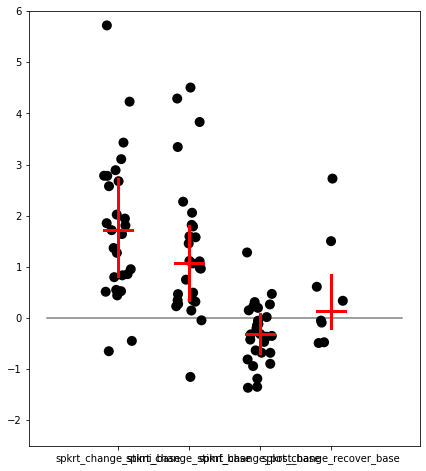

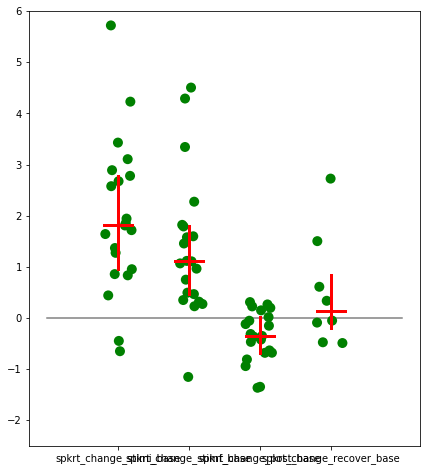

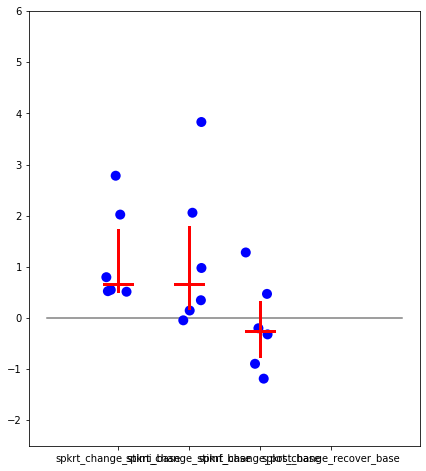

In [31]:
#######AENS changes in spike rate#########
plotdf = alldf[((alldf.cell=='aen')&
                (alldf.trigger_type=='paired')&
                (alldf.phase=='phase1'))][['spkrt_change_stimi_base','spkrt_change_stimf_base',
     'spkrt_change_post_base','spkrt_change_recover_base']]

fig = plt.figure(figsize=(7,8))
ax = sns.stripplot(data=plotdf,color='black',s=10,alpha=1,jitter=0.2)
# [ax.plot([0,1,2,3,4],sweep,color='grey') for sweep in plotdf[['base','stimi','stimf','post','recovery']].values];
plt.plot([-1,4],[0,0],color='grey')
colhead = plotdf.columns.to_list()
for i,c in enumerate(colhead):
    q = plotdf[c].quantile([.25, .5,0.75])                     
    ax.plot([i-0.2,i+0.2],[q.values[1],q.values[1]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[0]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[2]],color = 'red',lw = 3,zorder=30)
plt.ylim(-2.5,6)
plt.savefig('Figures/revisions/scatter_aen_spkrates_.eps', format='eps', dpi=1000)

#######and separate condition by color#######
####ventilation####
#plot changes in spike rate for each period
plotdf = alldf[((alldf.condition=='aen_vent')&
                (alldf.trigger_type=='paired')&
                (alldf.phase=='phase1'))][['spkrt_change_stimi_base','spkrt_change_stimf_base',
     'spkrt_change_post_base','spkrt_change_recover_base']]

fig = plt.figure(figsize=(7,8))
ax = sns.stripplot(data=plotdf,color='green',s=10,alpha=1,jitter=0.2)
# [ax.plot([0,1,2,3,4],sweep,color='grey') for sweep in plotdf[['base','stimi','stimf','post','recovery']].values];
plt.plot([-1,4],[0,0],color='grey')
colhead = plotdf.columns.to_list()
for i,c in enumerate(colhead):
    q = plotdf[c].quantile([.25, .5,0.75])                     
    ax.plot([i-0.2,i+0.2],[q.values[1],q.values[1]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[0]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[2]],color = 'red',lw = 3,zorder=30)
plt.ylim(-2.5,6)
plt.savefig('Figures/revisions/scatter_aenV_spkrates_.eps', format='eps', dpi=1000)

######fin lift######
#plot changes in spike rate for each period
plotdf = alldf[((alldf.condition=='aen_proprio')&
                (alldf.trigger_type=='paired')&
                (alldf.phase=='phase1'))][['spkrt_change_stimi_base','spkrt_change_stimf_base',
     'spkrt_change_post_base','spkrt_change_recover_base']]

fig = plt.figure(figsize=(7,8))
ax = sns.stripplot(data=plotdf,color='blue',s=10,alpha=1,jitter=0.2)
# [ax.plot([0,1,2,3,4],sweep,color='grey') for sweep in plotdf[['base','stimi','stimf','post','recovery']].values];
plt.plot([-1,4],[0,0],color='grey')
colhead = plotdf.columns.to_list()
for i,c in enumerate(colhead):
    q = plotdf[c].quantile([.25, .5,0.75])                     
    ax.plot([i-0.2,i+0.2],[q.values[1],q.values[1]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[0]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[2]],color = 'red',lw = 3,zorder=30)
plt.ylim(-2.5,6)
plt.savefig('Figures/revisions/scatter_aenFL_spkrates_.eps', format='eps', dpi=1000)


######STATS for population data#############
thisdf = alldf[((alldf.cell=='aen')&
                (alldf.trigger_type=='paired')&
                (alldf.phase=='phase1'))]

display(thisdf[['spkrt_base','spkrt_change_stimi_base','spkrt_change_stimf_stimi',
                                  'spkrt_change_post_base']].describe())

print('aen')
print('n = ' + str(len(thisdf)))
print('post-pairing to base: H0 =  post-pairing same as base')
r = scipy.stats.wilcoxon(thisdf['spkrt_post'].values,thisdf['spkrt_base'].values)
print(r)

print('aen')
print('stimulus initial to base: H0 =  stimi same as base')
r = scipy.stats.wilcoxon(thisdf['spkrt_stimi'].values,thisdf['spkrt_base'].values)
print(r)

print('aen')
print('stimulus change: H0 =  stimf same as stimi')
r = scipy.stats.wilcoxon(thisdf['spkrt_stimf'].values,thisdf['spkrt_stimi'].values)
print(r)

print('aen')
print('stimulus final to base: H0 =  stimf same as base')
r = scipy.stats.wilcoxon(thisdf['spkrt_stimf'].values,thisdf['spkrt_base'].values)
print(r)


In [32]:
r = stats.mannwhitneyu(alldf[((alldf.phase=='phase1')
       &(alldf.trigger_type=='paired')
       &(alldf.condition=='aen_vent'))]['spkrt_change_post_base'].values,
alldf[((alldf.phase=='phase1')
       &(alldf.trigger_type=='paired')
       &(alldf.condition=='aen_proprio'))]['spkrt_change_post_base'].values)
print('was there a difference between these conditions (vent or fin lift) for spike rates postpairing?')
print('n1=21 ventilation; n2=6 fin lift')
print(r)

was there a difference between these conditions (vent or fin lift) for spike rates postpairing?
n1=21 ventilation; n2=6 fin lift
MannwhitneyuResult(statistic=56.0, pvalue=0.35231137054800765)


n = 5

compare test versus control change in post-pairing and baseline 
Is change in post-pairing response from baseline different for control versus test AENs?
   wilcoxon compared within cells with baseline subtracted from post
WilcoxonResult(statistic=1.0, pvalue=0.6547208460185769)

compare each against median zero
aen test
WilcoxonResult(statistic=0.0, pvalue=0.17971249487899976)
sample size <20; norm distribution p = 0.17971249487899976
for n = 5, Wcritical = 0 at alpha = 0.05; Wcritical = 0 at alpha = 0.1

aen control
WilcoxonResult(statistic=0.0, pvalue=0.17971249487899976)
sample size <20; norm distribution p = 0.17971249487899976
for n = 5, Wcritical = 0 at alpha = 0.05; Wcritical = 0 at alpha = 0.1


/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


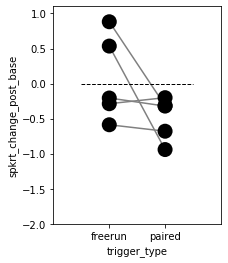

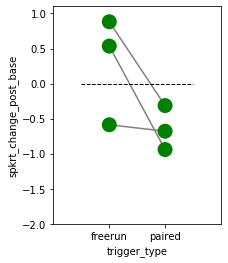

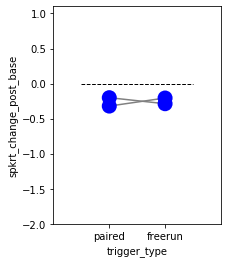

In [47]:
#############################
######### aens in which have control/freerun condition ###########
thisdf = alldf[(alldf.control=='yes')]

plt.figure(figsize=(3,4))
sns.stripplot(x='trigger_type',y='spkrt_change_post_base',data = thisdf,
              jitter=False,s=15,color='black')
[plt.plot([0,1],[x,y],color = 'gray') for x,y 
     in zip(thisdf[thisdf.trigger_type=='freerun']['spkrt_change_post_base'].values,
          thisdf[thisdf.trigger_type=='paired']['spkrt_change_post_base'].values)]
plt.xlim(-1,2)
plt.ylim(-2,1.1)
plt.plot([-0.5,1.5],[0,0],color = 'black',lw = 1,linestyle='--')
plt.savefig('Figures/revisions/scatter_aen_spkrates_controls.eps', format='eps', dpi=1000)

#####color by condition
thisdf = alldf[(alldf.control=='yes')&(alldf.condition=='aen_vent')]

plt.figure(figsize=(3,4))
sns.stripplot(x='trigger_type',y='spkrt_change_post_base',data = thisdf,
              jitter=False,s=15,color='green')
[plt.plot([0,1],[x,y],color = 'gray') for x,y 
     in zip(thisdf[thisdf.trigger_type=='freerun']['spkrt_change_post_base'].values,
          thisdf[thisdf.trigger_type=='paired']['spkrt_change_post_base'].values)]
plt.xlim(-1,2)
plt.ylim(-2,1.1)
plt.plot([-0.5,1.5],[0,0],color = 'black',lw = 1,linestyle='--')
plt.savefig('Figures/revisions/scatter_aenV_spkrates_controls.eps', format='eps', dpi=1000)

#############################
#########aens in which have control###########
thisdf = alldf[(alldf.control=='yes')&(alldf.condition=='aen_proprio')]

plt.figure(figsize=(3,4))
sns.stripplot(x='trigger_type',y='spkrt_change_post_base',data = thisdf,
              jitter=False,s=15,color='blue')
[plt.plot([0,1],[x,y],color = 'gray') for x,y 
     in zip(thisdf[thisdf.trigger_type=='paired']['spkrt_change_post_base'].values,
          thisdf[thisdf.trigger_type=='freerun']['spkrt_change_post_base'].values)]
plt.xlim(-1,2)
plt.ylim(-2,1.1)
plt.plot([-0.5,1.5],[0,0],color = 'black',lw = 1,linestyle='--')
plt.savefig('Figures/revisions/scatter_aenFL_spkrates_controls.eps', format='eps', dpi=1000)

########STATS########
#verbose stat tests for the single cell level changes compared across groups
print('n = 5')
print('')
print('compare test versus control change in post-pairing and baseline ')
print('Is change in post-pairing response from baseline different for control versus test AENs?')
print('   wilcoxon compared within cells with baseline subtracted from post')
r = scipy.stats.wilcoxon(thisdf[thisdf.trigger_type=='paired']['spkrt_change_post_base'].values,
                        thisdf[thisdf.trigger_type=='freerun']['spkrt_change_post_base'].values)
print(r)
print('')
print('compare each against median zero')
print('aen test')
r = scipy.stats.wilcoxon(thisdf[thisdf.trigger_type=='paired']['spkrt_change_post_base'].values)
print(r)
print('sample size <20; norm distribution p = ' + str(r[1]))
print('for n = 5, Wcritical = 0 at alpha = 0.05; Wcritical = 0 at alpha = 0.1')
print('')
print('aen control')
r = scipy.stats.wilcoxon(thisdf[thisdf.trigger_type=='freerun']['spkrt_change_post_base'].values)
print(r)
print('sample size <20; norm distribution p = ' + str(r[1]))
print('for n = 5, Wcritical = 0 at alpha = 0.05; Wcritical = 0 at alpha = 0.1')

spkrt_base  spkrt_change_stimi_base  spkrt_change_stimf_stimi  \
count    9.000000                 9.000000                  9.000000   
mean    10.887592                 0.809815                 -0.536576   
std     10.774643                 2.963645                  1.452809   
min      0.420904                -5.031473                 -3.540000   
25%      2.132622                -0.638889                 -1.457778   
50%      7.362791                 0.514120                 -0.085106   
75%     14.972222                 3.232429                  0.155556   
max     33.808140                 5.003876                  1.222222   

       spkrt_change_post_base  
count                9.000000  
mean                -1.047995  
std                  3.034190  
min                 -7.864806  
25%                 -2.552682  
50%                  0.223277  
75%                  0.559028  
max                  1.819562

n = 9
sample size <20; cannot use norm distribution for p
for n = 10, Wcritical = 8 at alpha = 0.05; Wcritical = 10 at alpha = 0.1
afferent
post-pairing to base: H0 =  post-pairing same as base
WilcoxonResult(statistic=19.0, pvalue=0.6784023758521882)
Ttest_relResult(statistic=-1.0361857021445595, pvalue=0.3304183976626629)

afferent
stimulus to base: H0 =  stimi same as base
WilcoxonResult(statistic=16.0, pvalue=0.44126813332892967)
Ttest_relResult(statistic=0.8197490170289373, pvalue=0.43609942456154926)

afferent
change stimulus: H0 =  stimf same as stimi
WilcoxonResult(statistic=14.0, pvalue=0.3139380937749148)
Ttest_relResult(statistic=-1.108009865435005, pvalue=0.30005515074814754)

outlier stiminitial respnse
22    20070719_91_coupled_SPK.mat
Name: exptname, dtype: object
outlier stim change respnse
Series([], Name: exptname, dtype: object)
outlier post pairing change 
22    20070719_91_coupled_SPK.mat
Name: exptname, dtype: object


/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


(-1, 1)

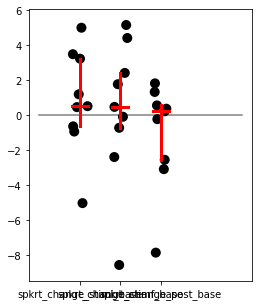

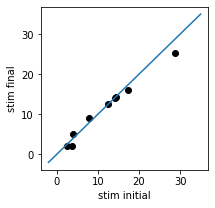

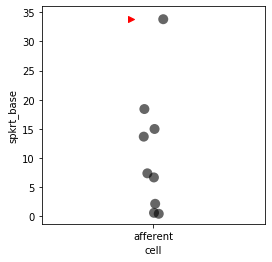

In [49]:
#######afferents changes in spike rate#########
thisdf = alldf[(alldf.cell=='afferent')] 

display(thisdf[['spkrt_base','spkrt_change_stimi_base','spkrt_change_stimf_stimi',
                                  'spkrt_change_post_base']].describe())

#plot changes in spike rate for each period
plotdf = thisdf[['spkrt_change_stimi_base','spkrt_change_stimf_base',
     'spkrt_change_post_base']]

fig = plt.figure(figsize=(4,5))
ax = sns.stripplot(data=plotdf,color='black',s=10,alpha=1,jitter=0.2)
plt.plot([-1,4],[0,0],color='grey')
colhead = plotdf.columns.to_list()
for i,c in enumerate(colhead):
    q = plotdf[c].quantile([.25, .5,0.75])                     
    ax.plot([i-0.2,i+0.2],[q.values[1],q.values[1]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[0]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[2]],color = 'red',lw = 3,zorder=30)
# plt.ylim(-2.5,6)
plt.savefig('Figures/revisions/scatter_afferent_spkrates_.eps', format='eps', dpi=1000)


lims = [-2,35]
fig= plt.figure(figsize = (3,3))
ax = plt.gca()
data = np.asarray([thisdf['spkrt_stimi'].values,thisdf['spkrt_stimf'].values]).T
plt.scatter(data[:,0],data[:,1],color='black')
plt.plot([lims[0],lims[1]],[lims[0],lims[1]])
plt.xlabel('stim initial')
plt.ylabel('stim final')


print('n = ' + str(len(thisdf)))
print('sample size <20; cannot use norm distribution for p')
print('for n = 10, Wcritical = 8 at alpha = 0.05; Wcritical = 10 at alpha = 0.1')

print('afferent')
print('post-pairing to base: H0 =  post-pairing same as base')
r = scipy.stats.wilcoxon(thisdf['spkrt_post'].values,thisdf['spkrt_base'].values)
print(r)
r = scipy.stats.ttest_rel(thisdf['spkrt_post'].values,thisdf['spkrt_base'].values)
print(r)
print('')

print('afferent')
print('stimulus to base: H0 =  stimi same as base')
r = scipy.stats.wilcoxon(thisdf['spkrt_stimi'].values,thisdf['spkrt_base'].values)
print(r)
r = scipy.stats.ttest_rel(thisdf['spkrt_stimi'].values,thisdf['spkrt_base'].values)
print(r)
print('')

print('afferent')
print('change stimulus: H0 =  stimf same as stimi')
r = scipy.stats.wilcoxon(thisdf['spkrt_stimf'].values,thisdf['spkrt_stimi'].values)
print(r)
r = scipy.stats.ttest_rel(thisdf['spkrt_stimf'].values,thisdf['spkrt_stimi'].values)
print(r)
print('')

print('outlier stiminitial respnse')
print(thisdf[(thisdf['spkrt_stimi'].values-thisdf['spkrt_base'].values)<-4].exptname)

print('outlier stim change respnse')
print(thisdf[(thisdf['spkrt_stimf'].values-thisdf['spkrt_stimi'].values)<-4].exptname)

print('outlier post pairing change ')
print(thisdf[(thisdf['spkrt_post'].values-thisdf['spkrt_base'].values)<-4].exptname)

thisdf[(thisdf['spkrt_post'].values-thisdf['spkrt_base'].values)<-4].spkrt_base

plt.figure(figsize=(4,4))
ax = sns.stripplot(x='cell',y='spkrt_base',data=thisdf,color='black',s=10,alpha=0.6,jitter=0.1)
plt.scatter(-0.2,thisdf[(thisdf['spkrt_post'].values-thisdf['spkrt_base'].values)<-4].spkrt_base,
           marker='>',color='red')
plt.xlim(-1,1)

**Fig 4C&D: Examine changes in temporal structure of responses** 
<br/>

First, to examine whether the observed poststimulus changes in AEN spike rate (Fig. 4A) preserved the temporal specificity of the stimulus-driven response, we estimated the trial-averaged spike rate per 200msec bin in each period of the experiment in each cell (Fig. 4C&D). We then aligned responses across cells according to the bin in which the maximum stimulus-driven spike rate was evoked. In the stimulus period, spike rates in this center bin were initially 10Hz (6.3--13; n=27 cells) above prestimulus rates (W=0; p<0.001; n=27 cells). Consistent with the previous results, the peak stimulus-driven spike rates decreased significantly by 1.1Hz (3.5 -- +0.3; n=27 cells) by the end of the stimulus period (Fig. 4C; center bin: W = 96; p = 0.025; n = 27 cells). As would be predicted by a temporally specific cancellation mechanism, we found that the poststimulus response was decreased relative to the prestimulus response only in the bins including and immediately surrounding the peak stimulus-driven response (Fig. 4C; center bin: -0.6Hz (-1.2 -- -0.2); W = 65; p = 0.003; n = 27 cells). Across the afferent population, peak stimulus-driven spike rates were also significantly elevated above prestimulus rates by 7.7Hz (7.3, 9.9) in the center bin (W=0; critical W at alpha(0.05) = 6 for n=9; Fig. 4D). However, this response did not decrease significantly by the end of the stimulus period (center bin: -1.7Hz, -2.6 -- -0.3; W = 9; critical W at alpha(0.05) = 6 for n=9). Finally, unlike AENs, afferents exhibited no difference between the poststimulus spiking response and the prestimulus spiking response in this (or any other) bins (Fig. 4D; center bin: -0.1Hz, -2.4 -- +0.2; W = 17; critical W at alpha(0.05) = 6 for n=9). These results indicate that changes in AEN spike rate cannot be accounted for by changes in the afferent input. These results are consistent with the generation of a cancellation signal within AENs themselves. 

In [ ]:
#functions for making and plotting raw histogram data
def get_response_hist(trigger_times,data_times,binw,trigger,trial_duration):
    #binw in seconds
    aligned_times = spiketimes_align(trigger_times,data_times,trigger,trial_duration)
    nbins = np.trunc(trial_duration/binw)
    r = np.histogram(aligned_times,np.linspace(0,nbins*binw,nbins+1))
    yh = r[0]/len(trigger_times)/binw
    xc = r[1]-np.mean(np.diff(r[1]))
    xc = xc[1:] # [0:len(yh)]
    
    return yh, xc

def get_stats_r(pop_response):
    p=[]
    w=[]
    for c in pop_response:
        inds = np.where(~np.isnan(c))[0]
        if len(inds)>5:
            r = stats.wilcoxon(c[inds])
            p.append(r[1])
            w.append(r[0])
        if len(inds)<=5:
            p.append(np.nan)
            w.append(np.nan)
    w = np.asarray(w)
    p = np.asarray(p)
    
    return w,p

def align_mat(_unaligned_):
    #row 0 is xtime
    #row 1 i baseline response (not z-scored)
    #row 2 is stimulus initial (mean of z-scored trials) which base alignment off of
    #row 3 is stimulus final (mean of z-scored trials) 
    #row 4 is post-pairing (mean of z-scored trials)
    #row 5 is recovery (mean of z-scored trials)

    #for each experiment, find length of data and get max length of all data = L
    L = np.max([len(mat) for mat in list(_unaligned_.values())])

    #for each experiment, 
    base_mat = []
    stimi_mat = []
    stimf_mat = []
    postpairing_mat = []
    recovery_mat = []
    xtime_mat = []

    for mat in list(_unaligned_.values()):
    #find the max peak of the stimulus response    
        sweep = mat[:,2]
        l = len(sweep)
        c_ind = np.argmax(sweep)
        pad_front = L-c_ind
        pad_back = L-(l-c_ind)

    #pad front and back of sweeps so that total 2L length
    #append each row of sweeps array to appropriate MetaMatrix
        sweep = mat[:,2]
        stimi_mat.append(np.pad(sweep, (pad_front,pad_back), 
                                'constant', constant_values=(np.nan, np.nan)))

        sweep = mat[:,0]
        thisx = np.pad(sweep, (pad_front,pad_back), 
                                'constant', constant_values=(np.nan, np.nan))
        xtime_mat.append(thisx - sweep[c_ind])

        sweep = mat[:,1]
        base_mat.append(np.pad(sweep, (pad_front,pad_back), 
                                'constant', constant_values=(np.nan, np.nan)))

        sweep = mat[:,3]
        stimf_mat.append(np.pad(sweep, (pad_front,pad_back), 
                                'constant', constant_values=(np.nan, np.nan)))

        sweep = mat[:,4]
        postpairing_mat.append(np.pad(sweep, (pad_front,pad_back), 
                                'constant', constant_values=(np.nan, np.nan)))

        sweep = mat[:,5]
        recovery_mat.append(np.pad(sweep, (pad_front,pad_back), 
                                'constant', constant_values=(np.nan, np.nan)))

    base_ = np.asarray(base_mat).T
    stimi_ = np.asarray(stimi_mat).T
    stimf_ = np.asarray(stimf_mat).T
    postpairing_ = np.asarray(postpairing_mat).T
    recovery_ = np.asarray(recovery_mat).T
    xtime_ = np.asarray(xtime_mat).T
    
    return base_, stimi_, stimf_, postpairing_, recovery_, xtime_

def get_meta_data():
    cell = []
    condition = []
    trigger_type = []
    phase = []
    exptname = []
    
    for iexpt,thisexpt_name in enumerate(meta.exptname):
        thisexpt = meta.loc[meta['exptname'] == thisexpt_name]
        exptname.append(thisexpt_name)
        cell.append(thisexpt.cell.values[0])
        condition.append(thisexpt.condition.values[0])
        trigger_type.append(thisexpt.trigger_type.values[0])
        phase.append(thisexpt.phase.values[0])
    
    df_meta = pd.DataFrame({
        'exptname' : exptname,
        'cell' : cell,
        'condition' : condition,
        'trigger_type' : trigger_type,
        'phase' : phase
        })
    return df_meta
        
def process_meta_data(iexpt,thisexpt_name):

    thisexpt = meta.loc[meta['exptname'] == thisexpt_name]

    trial_duration = thisexpt.trial_duration.values[0]

    basename = thisexpt_name[0:-8]
    data_folder = Path.cwd() / basename
    file_to_open = data_folder / Path(basename + '.smr')
    bl = Spike2IO(file_to_open,try_signal_grouping=False).read_block()
    
    trigger = []
    for sublist in np.asarray([seg.events[[s.name for 
       s in seg.events].index(thisexpt.chan_trigger.values[0])].magnitude 
       for seg in bl.segments]):
        for item in sublist:
            trigger.append(item)
    trigger = np.asarray(trigger)
    
    if thisexpt.spike_times_from.values[0] == 'Spyking-Circus':
        spikes = np.load(data_folder / 'spikes.npy')

    if thisexpt.spike_times_from.values[0] == 'Spike2':
        spikes = []
        for sublist in np.asarray([seg.events[[s.name for 
           s in seg.events].index(thisexpt.chan_spikes.values[0])].magnitude 
           for seg in bl.segments]):
            for item in sublist:
                spikes.append(item)
        spikes = np.asarray(spikes)

    postpairing_range = get_range_bounds([thisexpt.post_start.values[0],thisexpt.post_stop.values[0]],trigger)
    stim_range = get_range_bounds([thisexpt.stim_start.values[0],thisexpt.stim_stop.values[0]],trigger)
    base_range = get_range_bounds([thisexpt.base_start.values[0],thisexpt.base_stop.values[0]],trigger)

    if thisexpt_name == '20060812_3066_SPK.mat':
        #removing a few trials in which spike detection mis-triggered
        removeinds = np.arange(360,np.max(postpairing_range)-1,1)
        [postpairing_range.remove(x) for x in removeinds]
        removeinds = [263, 264, 265, 326, 327] #, 360, 401, 407, 408, 409, 423, 424]
        [postpairing_range.remove(x) for x in removeinds]
 
    return (trial_duration, spikes, trigger, base_range, stim_range, postpairing_range)

def process_raw_responses_hist():
    dt = 1/1000 
    ntrials_per_period = 75 #this could be a parameter to play with, but want it to be consistent across all experiments

    unaligned_ = {}
    binw = 0.2
    recovery = []

    for iexpt,thisexpt_name in enumerate(meta.exptname):
        (trial_duration, spikes, trigger, base_range, 
         stim_range, postpairing_range) = process_meta_data(iexpt,thisexpt_name)

        these_trials = base_range
        yh, xc = get_response_hist(these_trials,spikes,binw,trigger,trial_duration)
        baseline_response = yh

        if thisexpt_name == '20071025_3335_control_SPK.mat': 
        #not enough baseline recorded so get estimate of baseline from test cell clock trigger baseline
            print('using pre pairing expt to get baseline (recovery end)')
            suppname = '20071025_3335_SPK.mat'
            suppexpt = meta.loc[meta['exptname'] == suppname]
            basename = suppname[0:-8]
            data_folder = Path.cwd() / basename
            supptrigger = np.arange(suppexpt.post_stop.values[0]-250,suppexpt.post_stop.values[0],trial_duration)
            suppbase_range = np.arange(0,len(supptrigger),1)
            base_range = suppbase_range

            suppspikes = np.load(data_folder / 'spikes.npy')

            baseline_response, xc = get_response_hist(suppbase_range,suppspikes,binw,supptrigger,trial_duration)

        if thisexpt_name == '20071026_3108_control_SPK.mat': 
        #not enough baseline recorded so get estimate of baseline from test cell clock trigger baseline
            print('using pre pairing expt to get baseline')
            suppname = '20071026_3108_SPK.mat'
            suppexpt = meta.loc[meta['exptname'] == suppname]
            basename = suppname[0:-8]
            data_folder = Path.cwd() / basename
            file_to_open = data_folder / Path(basename + '.smr')
            bl = Spike2IO(file_to_open,try_signal_grouping=False).read_block()
            supptrigger = np.arange(0,suppexpt.base_stop.values[0],trial_duration)
            suppbase_range = np.arange(0,len(supptrigger),1)
            base_range = suppbase_range

            suppspikes = []
            for sublist in np.asarray([seg.events[[s.name for 
               s in seg.events].index(suppexpt.chan_spikes.values[0])].magnitude 
               for seg in bl.segments]):
                for item in sublist:
                    suppspikes.append(item)
            suppspikes = np.asarray(suppspikes)

            baseline_response, xc = get_response_hist(suppbase_range,suppspikes,binw,supptrigger,trial_duration)    

        ntrials = np.min([len(stim_range),ntrials_per_period*2])
        stiminitial_trials = stim_range[0:int(ntrials/2)]
        stiminitial_response, xc = get_response_hist(stiminitial_trials,spikes,binw,trigger,trial_duration)

        stimfinal_trials = stim_range[-int(ntrials/2):]
        stimfinal_response, xc = get_response_hist(stimfinal_trials,spikes,binw,trigger,trial_duration)

        ntrials = np.min([len(postpairing_range),ntrials_per_period])
        postpairing_trials = postpairing_range[0:ntrials]
        postpairing_response, xc = get_response_hist(postpairing_trials,spikes,binw,trigger,trial_duration)

        recovery_response = np.empty(len(baseline_response))
        if len(postpairing_range)>=200+ntrials_per_period:
            recovery_trials = postpairing_range[200:200+ntrials_per_period]
            recovery_response, xc = get_response_hist(recovery_trials,spikes,binw,trigger,trial_duration)
            recovery.append(True)
        if len(postpairing_range)<200+ntrials_per_period:
            recovery.append(False)

        thisRmat = np.asarray([xc,
            baseline_response,
            stiminitial_response,
            stimfinal_response,
            postpairing_response,
            recovery_response])

        unaligned_[thisexpt_name] = thisRmat.T

    return unaligned_

def do_strip_plot(ind):
    plotdf = pd.DataFrame({
    'stim' : this_stimf[ind,:] - this_stimi[ind,:],
    'post' : this_post[ind,:] - this_base[ind,:]
    })
    fig = plt.figure(figsize=(3,5))
    ax = sns.stripplot(data=plotdf,color='black',s=7,alpha=1,jitter=0.2)
    plt.plot([-1,2],[0,0],color='grey')
    colhead = plotdf.columns.to_list()
    for i,c in enumerate(colhead):
        q = plotdf[c].quantile([.25, .5,0.75])                     
        ax.plot([i-0.2,i+0.2],[q.values[1],q.values[1]],color = 'red',lw = 3,zorder=30)
        ax.plot([i,i],[q.values[1],q.values[0]],color = 'red',lw = 3,zorder=30)
        ax.plot([i,i],[q.values[1],q.values[2]],color = 'red',lw = 3,zorder=30)
    return ax

In [11]:
############# do the binned analysis from above functions #######
meta = pd.read_csv('MetaData.csv')
hist_unaligned_ = process_raw_responses_hist()

df_meta = get_meta_data()
df_meta = df_meta[df_meta.exptname!='20180407_freerun2_SPK.mat']
base_mat, stimi_mat, stimf_mat, postpairing_mat, recovery_mat, xtime_mat = align_mat(hist_unaligned_)

/anaconda3/lib/python3.6/site-packages/neo-0.8.0.dev0-py3.6.egg/neo/rawio/spike2rawio.py:609: RuntimeWarning: overflow encountered in short_scalars
  info['time_per_adc']) * 1e-6
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


using pre pairing expt to get baseline (recovery end)
using pre pairing expt to get baseline


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning

peak stimulus response bin
n = 27
stimulus-evoked response relative to base
quantiles
[ 6.25522388  9.99735772 12.99284155]
WilcoxonResult(statistic=0.0, pvalue=5.606116527496013e-06)

change in stimulus-evoked response
quantiles
[-3.53333333 -1.13333333  0.3       ]
WilcoxonResult(statistic=96.0, pvalue=0.025456403148726894)

change in baseline response after pairing
quantiles
[-1.24252022 -0.58902954 -0.21315193]
WilcoxonResult(statistic=65.0, pvalue=0.0028909652879307935)



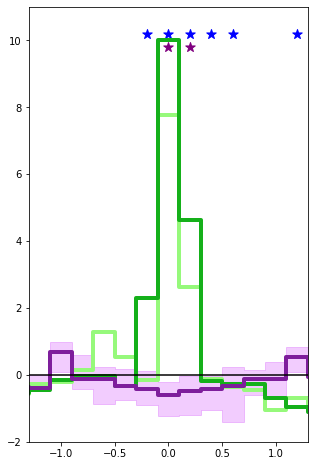

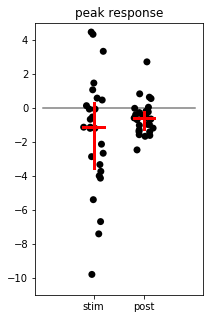

In [23]:
####sort results for AENs########
celltype = 'aen'
dfinds = df_meta[(df_meta['cell']==celltype)&
         (df_meta['trigger_type']=='paired')&
         (df_meta['phase']=='phase1')&
         (df_meta['condition']!='aen_swimcmd')&
         (df_meta['condition']!='aen_ventcmd')].index

this_x = xtime_mat[:,dfinds]
xtime = np.nanmean(this_x,1)

#######only plot between -1.5 and 1.5 sec around center bin
xinds = np.where((xtime>-1.5)&(xtime<1.5))[0]
xtime = xtime[xinds]
binw = np.round(np.mean(np.diff(xtime)),3)

this_base = base_mat[:,dfinds][xinds,:]
this_stimi = stimi_mat[:,dfinds][xinds,:]
this_stimf = stimf_mat[:,dfinds][xinds,:]
this_post = postpairing_mat[:,dfinds][xinds,:]
this_recovery = recovery_mat[:,dfinds][xinds,:]

n = [len(c[~np.isnan(c)]) for c in this_base]

plt.figure(figsize=(5,8))
r = np.nanquantile((this_stimf-this_base),[0.25,0.5,0.75],axis=1)
plt.step(xtime,r[1],color = sns.xkcd_rgb['light green'],lw = 4,where='mid')#np.nanmean(this_stimi-this_base,1));
r = np.nanquantile((this_stimi-this_base),[0.25,0.5,0.75],axis=1)
plt.step(xtime,r[1],color = sns.xkcd_rgb['green'],lw = 4,where='mid')#np.nanmean(this_stimi-this_base,1));

####shade IQR around poststimulus response#####
####indicate bins that were significant at 0.01 or 0.05#####
w,p = get_stats_r((this_post-this_base))
r = np.nanquantile((this_post-this_base),[0.25,0.5,0.75],axis=1)
plt.step(xtime,r[1],color = sns.xkcd_rgb['purple'],lw=4,where='mid')#np.nanmean(this_stimi-this_base,1));
plt.fill_between(xtime,r[0],r[2],step='mid',color = sns.xkcd_rgb['bright purple'],alpha = 0.2)

for x_,p_ in zip(xtime,p):
    if p_<0.01:
        plt.scatter(x_,9.8,color='purple',marker='*',s=100)
for x_,p_ in zip(xtime,p):
    if p_<0.05:
        plt.scatter(x_,10.2,color='blue',marker='*',s=100)
plt.plot([-1.3,1.3],[0,0],color = 'black')
plt.xlim(-1.3,1.3)
plt.ylim(-2,11)
plt.savefig('Figures/revisions/histogram_StimPeakAligned_' + celltype + '.eps', format='eps', dpi=1000)

#plot scatter of changes in center bin spike rate for each period
ind = np.where(xtime==0)[0][0]
ax = do_strip_plot(ind)
plt.ylim(-11,5)
ax.set_title('peak response')
plt.savefig('Figures/revisions/histogram_StimPeakBin_scatter_' + celltype + '.eps', format='eps', dpi=1000)

######color by ventialtion trigger#####
celltype = 'aen_vent'
dfinds = df_meta[(df_meta['condition']==celltype)&
         (df_meta['trigger_type']=='paired')&
         (df_meta['phase']=='phase1')&
         (df_meta['condition']!='aen_swimcmd')&
         (df_meta['condition']!='aen_ventcmd')].index

this_x = xtime_mat[:,dfinds]
xtime = np.nanmean(this_x,1)

xinds = np.where((xtime>-1.5)&(xtime<1.5))[0]
xtime = xtime[xinds]
binw = np.round(np.mean(np.diff(xtime)),3)

this_base = base_mat[:,dfinds][xinds,:]
this_stimi = stimi_mat[:,dfinds][xinds,:]
this_stimf = stimf_mat[:,dfinds][xinds,:]
this_post = postpairing_mat[:,dfinds][xinds,:]
this_recovery = recovery_mat[:,dfinds][xinds,:]

n = [len(c[~np.isnan(c)]) for c in this_base]

#plot scatter of changes in spike rate for each period
ind = np.where(xtime==0)[0][0]
plotdf = pd.DataFrame({
'stim' : this_stimf[ind,:] - this_stimi[ind,:],
'post' : this_post[ind,:] - this_base[ind,:]
})
fig = plt.figure(figsize=(3,5))
ax = sns.stripplot(data=plotdf,color=sns.xkcd_rgb['bright purple'],s=7,alpha=1,jitter=0.2)
plt.plot([-1,2],[0,0],color='grey')
plt.ylim(-11,5)
ax.set_title('peak response')
plt.savefig('Figures/revisions/histogram_StimPeakBin_scatter_V' + celltype + '.eps', format='eps', dpi=1000)


###color by Fin lift trigger###
celltype = 'aen_proprio'
dfinds = df_meta[(df_meta['condition']==celltype)&
         (df_meta['trigger_type']=='paired')&
         (df_meta['phase']=='phase1')&
         (df_meta['condition']!='aen_swimcmd')&
         (df_meta['condition']!='aen_ventcmd')].index

this_x = xtime_mat[:,dfinds]
xtime = np.nanmean(this_x,1)

xinds = np.where((xtime>-1.5)&(xtime<1.5))[0]
xtime = xtime[xinds]
binw = np.round(np.mean(np.diff(xtime)),3)

this_base = base_mat[:,dfinds][xinds,:]
this_stimi = stimi_mat[:,dfinds][xinds,:]
this_stimf = stimf_mat[:,dfinds][xinds,:]
this_post = postpairing_mat[:,dfinds][xinds,:]
this_recovery = recovery_mat[:,dfinds][xinds,:]

n = [len(c[~np.isnan(c)]) for c in this_base]

#plot scatter of changes in spike rate for each period
ind = np.where(xtime==0)[0][0]
plotdf = pd.DataFrame({
'stim' : this_stimf[ind,:] - this_stimi[ind,:],
'post' : this_post[ind,:] - this_base[ind,:]
})
fig = plt.figure(figsize=(3,5))
ax = sns.stripplot(data=plotdf,color=sns.xkcd_rgb['bright purple'],s=7,alpha=1,jitter=0.2)
plt.plot([-1,2],[0,0],color='grey')
plt.ylim(-11,5)
ax.set_title('peak response')
plt.savefig('Figures/revisions/histogram_StimPeakBin_scatter_FL' + celltype + '.eps', format='eps', dpi=1000)



#########################################
###############STATS#####################
print('peak stimulus response bin')
print('n = ' + str(len(this_base[ind,:])))
print('stimulus-evoked response relative to base')
print('quantiles')
q = np.nanquantile(this_stimi[ind,:] - this_base[ind,:],q = [0.25,0.5,0.75])
print(q)
r = stats.wilcoxon(this_stimi[ind,:], this_base[ind,:])
print(r)
print('')
print('change in stimulus-evoked response')
print('quantiles')
q = np.nanquantile(this_stimf[ind,:] - this_stimi[ind,:],q = [0.25,0.5,0.75])
print(q)
r = stats.wilcoxon(this_stimf[ind,:], this_stimi[ind,:])
print(r)
print('')
print('change in baseline response after pairing')
print('quantiles')
q = np.nanquantile(this_post[ind,:] - this_base[ind,:],q = [0.25,0.5,0.75])
print(q)
r = stats.wilcoxon(this_post[ind,:], this_base[ind,:])
print(r)
print('')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/l

peak stimulus response bin
n = 9
stimulus-evoked response relative to base
quantiles
[7.28926554 7.74545455 9.88475177]
WilcoxonResult(statistic=0.0, pvalue=0.007685794055213263)

change in stimulus-evoked response
quantiles
[-2.6        -1.66666667 -0.31914894]
WilcoxonResult(statistic=9.0, pvalue=0.10974463874701328)

change in baseline response after pairing
quantiles
[-2.35701754 -0.11073446  0.15162602]
WilcoxonResult(statistic=17.0, pvalue=0.5146697234497355)



/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


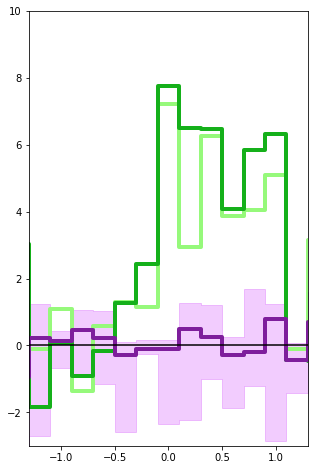

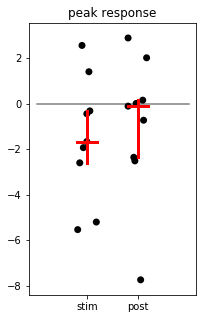

In [80]:
####sort results for AENs########
celltype = 'afferent'
dfinds = df_meta[(df_meta['cell']==celltype)].index

this_x = xtime_mat[:,dfinds]
xtime = np.nanmean(this_x,1)

xinds = np.where((xtime>-1.5)&(xtime<1.5))[0]
xtime = xtime[xinds]
binw = np.round(np.mean(np.diff(xtime)),3)

this_base = base_mat[:,dfinds][xinds,:]
this_stimi = stimi_mat[:,dfinds][xinds,:]
this_stimf = stimf_mat[:,dfinds][xinds,:]
this_post = postpairing_mat[:,dfinds][xinds,:]
this_recovery = recovery_mat[:,dfinds][xinds,:]

n = [len(c[~np.isnan(c)]) for c in this_base]

plt.figure(figsize=(5,8))
r = np.nanquantile((this_stimf-this_base),[0.25,0.5,0.75],axis=1)
plt.step(xtime,r[1],color = sns.xkcd_rgb['light green'],lw = 4,where='mid')#np.nanmean(this_stimi-this_base,1));
r = np.nanquantile((this_stimi-this_base),[0.25,0.5,0.75],axis=1)
plt.step(xtime,r[1],color = sns.xkcd_rgb['green'],lw = 4,where='mid')#np.nanmean(this_stimi-this_base,1));

####shade IQR around poststimulus response#####
####indicate bins that were significant at 0.01#####
w,p = get_stats_r((this_post-this_base))
r = np.nanquantile((this_post-this_base),[0.25,0.5,0.75],axis=1)
plt.step(xtime,r[1],color = sns.xkcd_rgb['purple'],lw=4,where='mid')#np.nanmean(this_stimi-this_base,1));
plt.fill_between(xtime,r[0],r[2],step='mid',color = sns.xkcd_rgb['bright purple'],alpha = 0.2)

for x_,p_ in zip(xtime,p):
    if p_<0.01:
        plt.scatter(x_,9.8,color='purple',marker='*',s=100)
plt.plot([-1.3,1.3],[0,0],color = 'black')
plt.xlim(-1.3,1.3)
plt.ylim(-3,10)
plt.savefig('Figures/revisions/histogram_StimPeakAligned_' + celltype + '.eps', format='eps', dpi=1000)

#plot changes in spike rate for each period
ind = np.where(xtime==0)[0][0]
ax = do_strip_plot(ind)
ax.set_title('peak response')
plt.savefig('Figures/revisions/histogram_StimPeakBin_scatter_' + celltype + '.eps', format='eps', dpi=1000)

#################################
###########STATS################
print('peak stimulus response bin')
print('n = ' + str(len(this_base[ind,:])))
print('stimulus-evoked response relative to base')
print('quantiles')
q = np.nanquantile(this_stimi[ind,:] - this_base[ind,:],q = [0.25,0.5,0.75])
print(q)
r = stats.wilcoxon(this_stimi[ind,:], this_base[ind,:])
print(r)
print('')
print('change in stimulus-evoked response')
print('quantiles')
q = np.nanquantile(this_stimf[ind,:] - this_stimi[ind,:],q = [0.25,0.5,0.75])
print(q)
r = stats.wilcoxon(this_stimf[ind,:], this_stimi[ind,:])
print(r)
print('')
print('change in baseline response after pairing')
print('quantiles')
q = np.nanquantile(this_post[ind,:] - this_base[ind,:],q = [0.25,0.5,0.75])
print(q)
r = stats.wilcoxon(this_post[ind,:], this_base[ind,:])
print(r)
print('')

**Figure 5: Test whether spiking becomes more negatively correlated with the stimulus response after pairing.**

--> We preserved the pattern of spike times by estimating an instantaneous spike density function (Fig5A&B; refer to Methods for more detail). We then measured the Spearman’s correlation between 1) the prestimulus response and the stimulus response and 2) the poststimulus response and the stimulus response. Within each cell, we compared the correlation between the poststimulus response and the stimulus response to the correlation between the prestimulus response and the stimulus response. In the paired condition, just as predicted, AENs had a poststimulus response that was more negatively correlated with the stimulus response than it was prestimulus (Fig5C; difference in correlation = -0.18 (-0.52 – -0.03); W = 80; p=0.009; n=27 cells). Afferents exhibited no change in the correlation with the stimulus response between the post and prestimulus periods (Fig5C; difference in correlation = 0 (-0.13 – 0.5); W = 18; critical W at alpha(0.05)=8 for 9 cells). For the subset of AENs tested in both the paired and the freerun experimental condition, the poststimulus response was more negatively correlated to the stimulus response in the paired condition than in the freerun condition in all 5/5 cells (Fig5D; W = 0; critical W at alpha(0.05) = 0 for n=5; same cells as those in the analysis corresponding to Fig4B). Under the freerun condition, the AENs were prevented from forming their negative image of the stimulus response. In other words, yoking an external stimulus to a behavioral signal led to a post-pairing response in AENs that was like a negative image of the stimulus response, and this effect was specific to the AEN population. 

AENs change in spearmans correlation poststimulus versus prestimulus:


sp_poststim_mean  sp_basestim_mean  sp_change
count         27.000000         27.000000  27.000000
mean          -0.196477          0.033320  -0.229797
std            0.344114          0.343983   0.446700
min           -0.711848         -0.728269  -1.151269
25%           -0.463366         -0.187173  -0.522295
50%           -0.214484          0.108765  -0.185130
75%           -0.001742          0.245227  -0.033849
max            0.772056          0.495683   0.705711

 
aen
n = 27
post-pairing: H0 =  post-pairing same as base
WilcoxonResult(statistic=80.0, pvalue=0.00882590938459905)
 
are the proprio and fin lift groups significantly different from each other?
n1= 21
n2= 6
MannwhitneyuResult(statistic=56.0, pvalue=0.35231137054800765)
 
 
afferents change in spearmans correlation poststimulus versus prestimulus:


sp_poststim_mean  sp_basestim_mean  sp_change
count          9.000000          9.000000   9.000000
mean           0.143354         -0.140081   0.283436
std            0.508055          0.437160   0.688481
min           -0.963321         -0.877539  -0.278421
25%            0.046777         -0.441290  -0.129415
50%            0.212414          0.044780   0.000300
75%            0.287136          0.184206   0.494192
max            0.947601          0.341829   1.825140

 
n = 9
post-pairing: H0 =  post-pairing same as base
WilcoxonResult(statistic=18.0, pvalue=0.5939546753269146)


/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


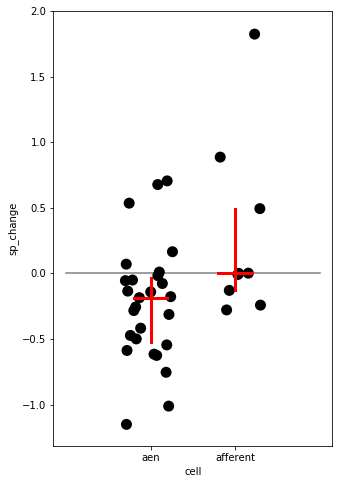

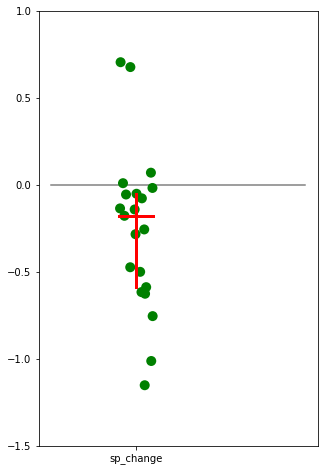

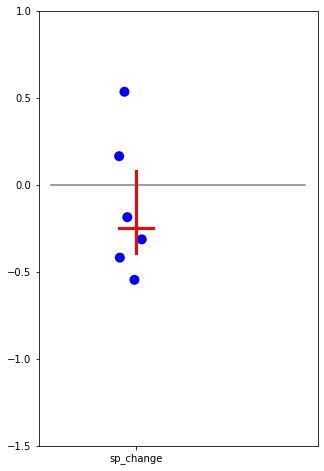

In [66]:
######################################
####plot change in spearmans by group cell type: AENs and afferents########

plotdf = pd.concat([alldf[(alldf.cell=='aen')&(alldf.phase=='phase1')&(alldf.trigger_type=='paired')],
                alldf[alldf.cell=='afferent']],sort=True)

fig = plt.figure(figsize=(5,8))
ax = sns.stripplot(x='cell', y='sp_change', data=plotdf,color='black',s=11,alpha=1,jitter=0.3)
plt.plot([-1,2],[0,0],color='grey')
q = plotdf[plotdf.cell=='aen']['sp_change'].quantile([.25, .5,0.75])
i=0
ax.plot([i-0.2,i+0.2],[q.values[1],q.values[1]],color = 'red',lw = 3,zorder=30)
ax.plot([i,i],[q.values[1],q.values[0]],color = 'red',lw = 3,zorder=30)
ax.plot([i,i],[q.values[1],q.values[2]],color = 'red',lw = 3,zorder=30)
q = plotdf[plotdf.cell=='afferent']['sp_change'].quantile([.25, .5,0.75])
i=1
ax.plot([i-0.2,i+0.2],[q.values[1],q.values[1]],color = 'red',lw = 3,zorder=30)
ax.plot([i,i],[q.values[1],q.values[0]],color = 'red',lw = 3,zorder=30)
ax.plot([i,i],[q.values[1],q.values[2]],color = 'red',lw = 3,zorder=30)
plt.savefig('Figures/revisions/scatter_sp_change_cellGrouped.eps', format='eps', dpi=1000)


####### and color AENs by condition ##########
#plot changes in spearmans for each period
plotdf = alldf[((alldf.condition=='aen_vent')&
                (alldf.trigger_type=='paired')&
                (alldf.phase=='phase1'))][['sp_change']]

fig = plt.figure(figsize=(5,8))
ax = sns.stripplot(data=plotdf,color='green',s=10,alpha=1,jitter=0.2)
plt.plot([-1,2],[0,0],color='grey')
colhead = plotdf.columns.to_list()
for i,c in enumerate(colhead):
    q = plotdf[c].quantile([.25, .5,0.75])                     
    ax.plot([i-0.2,i+0.2],[q.values[1],q.values[1]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[0]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[2]],color = 'red',lw = 3,zorder=30)
plt.ylim(-1.5,1)

plt.savefig('Figures/revisions/scatter_aenV_sp_change_.eps', format='eps', dpi=1000)

#plot changes in spearmans for each period
plotdf = alldf[((alldf.condition=='aen_proprio')&
                (alldf.trigger_type=='paired')&
                (alldf.phase=='phase1'))][['sp_change']]

fig = plt.figure(figsize=(5,8))
ax = sns.stripplot(data=plotdf,color='blue',s=10,alpha=1,jitter=0.2)
plt.plot([-1,2],[0,0],color='grey')
colhead = plotdf.columns.to_list()
for i,c in enumerate(colhead):
    q = plotdf[c].quantile([.25, .5,0.75])                     
    ax.plot([i-0.2,i+0.2],[q.values[1],q.values[1]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[0]],color = 'red',lw = 3,zorder=30)
    ax.plot([i,i],[q.values[1],q.values[2]],color = 'red',lw = 3,zorder=30)
plt.ylim(-1.5,1)

plt.savefig('Figures/revisions/scatter_aenFL_sp_change_.eps', format='eps', dpi=1000)


############ STATS #########

#######changes in spearmans correlation between post-stim and pre-stim and stim#########
print('AENs change in spearmans correlation poststimulus versus prestimulus:')
thisdf = alldf[((alldf.cell=='aen')&
                (alldf.trigger_type=='paired')&
                (alldf.phase=='phase1'))]

display(thisdf[['sp_poststim_mean','sp_basestim_mean','sp_change']].describe())

print(' ')
print('aen')
print('n = ' + str(len(thisdf)))
print('post-pairing: H0 =  post-pairing same as base')
r = scipy.stats.wilcoxon(thisdf['sp_change'].values)
print(r)

print(' ')
print('are the proprio and fin lift groups significantly different from each other?')
plotdf = alldf[((alldf.cell=='aen')&
                (alldf.trigger_type=='paired')&
                (alldf.phase=='phase1'))][['sp_change','condition']]
r = scipy.stats.mannwhitneyu(plotdf[plotdf.condition=='aen_vent']['sp_change'].values,
                        plotdf[plotdf.condition=='aen_proprio']['sp_change'].values)
print('n1= ' + str(len(plotdf[plotdf.condition=='aen_vent'])))
print('n2= ' + str(len(plotdf[plotdf.condition=='aen_proprio'])))
print(r)

print(' ')
print(' ')
print('afferents change in spearmans correlation poststimulus versus prestimulus:')
thisdf = alldf[((alldf.cell=='afferent'))]

display(thisdf[['sp_poststim_mean','sp_basestim_mean','sp_change']].describe())

print(' ')
print('n = ' + str(len(thisdf)))
print('post-pairing: H0 =  post-pairing same as base')
r = scipy.stats.wilcoxon(thisdf['sp_change'].values)
print(r)

 **
 
5 control cells
change in response between post-pairing and baseline
Is change in post-pairing response the same in AENs under control conditions
for sample sizes = 5, critical W=0 at alpha(0.05)
 
   wilcoxon compared before and after pairing
 
aen H0 = post-stim to base-stim correlations the same in each cell?
WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)
 
 
what percent of data points lie below the unity line for aen test versus control
100
 
 
change in response between post-pairing and baseline compared to a median
Is change in post-pairing response the same in AENs under control or test conditions
 
   wilcoxon compared to median
 
aen freerun control H0 = post-stim to base-stim correlations the same as distribution with median 0
WilcoxonResult(statistic=7.0, pvalue=0.892738400944348)
 
 
aen paired test H0 = post-stim to base-stim correlations the same as distribution with median 0
WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)
 
 


/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


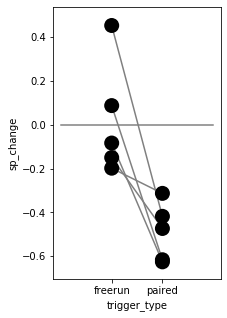

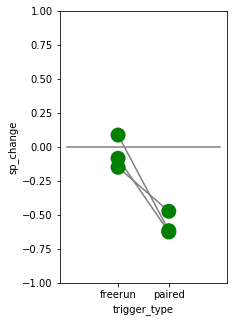

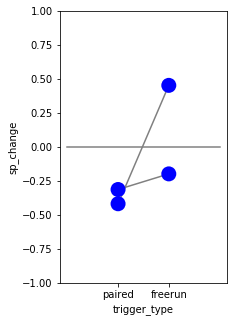

In [67]:
#############################
#########plot control for AENS ###########

plotdf = alldf[alldf.control=='yes']
fig = plt.figure(figsize=(3,5))
ax = sns.stripplot(x='trigger_type', y='sp_change', data=plotdf,color='black',s=15,alpha=1,jitter=False)
# [ax.plot([0,1,2,3,4],sweep,color='grey') for sweep in plotdf[['base','stimi','stimf','post','recovery']].values];
plt.plot([-1,2],[0,0],color='grey')
[plt.plot([0,1],[x,y],color = 'gray') for x,y in zip(plotdf[plotdf.trigger_type=='freerun']['sp_change'].values,
            plotdf[plotdf.trigger_type=='paired']['sp_change'].values)]
plt.savefig('Figures/revisions/scatter_sp_change_control.eps', format='eps', dpi=1000)

plotdf = alldf[(alldf.control=='yes')&(alldf.condition=='aen_vent')]
fig = plt.figure(figsize=(3,5))
ax = sns.stripplot(x='trigger_type', y='sp_change', data=plotdf,color='green',s=15,alpha=1,jitter=False)
# [ax.plot([0,1,2,3,4],sweep,color='grey') for sweep in plotdf[['base','stimi','stimf','post','recovery']].values];
plt.plot([-1,2],[0,0],color='grey')
[plt.plot([0,1],[x,y],color = 'gray') for x,y in zip(plotdf[plotdf.trigger_type=='freerun']['sp_change'].values,
            plotdf[plotdf.trigger_type=='paired']['sp_change'].values)]
plt.ylim(-1,1)
plt.savefig('Figures/revisions/scatter_sp_change_control_V.eps', format='eps', dpi=1000)

plotdf = alldf[(alldf.control=='yes')&(alldf.condition=='aen_proprio')]
fig = plt.figure(figsize=(3,5))
ax = sns.stripplot(x='trigger_type', y='sp_change', data=plotdf,color='blue',s=15,alpha=1,jitter=False)
# [ax.plot([0,1,2,3,4],sweep,color='grey') for sweep in plotdf[['base','stimi','stimf','post','recovery']].values];
plt.plot([-1,2],[0,0],color='grey')
[plt.plot([0,1],[x,y],color = 'gray') for x,y in zip(plotdf[plotdf.trigger_type=='paired']['sp_change'].values,
            plotdf[plotdf.trigger_type=='freerun']['sp_change'].values)]
plt.ylim(-1,1)
plt.savefig('Figures/revisions/scatter_sp_change_control_FL.eps', format='eps', dpi=1000)


######### STATS #########
print(' **')
print(' ')
print('5 control cells')
print('change in response between post-pairing and baseline')
print('Is change in post-pairing response the same in AENs under control conditions')
print('for sample sizes = 5, critical W=0 at alpha(0.05)')
print(' ')
print('   wilcoxon compared before and after pairing')
print(' ')
print('aen H0 = post-stim to base-stim correlations the same in each cell?')
r = scipy.stats.wilcoxon(alldf[(alldf.trigger_type=='freerun')&(alldf.control=='yes')]['sp_change'].values,
                         alldf[(alldf.trigger_type=='paired')&(alldf.control=='yes')]['sp_change'].values)
print(r)

print(' ')
print(' ')
print('what percent of data points lie below the unity line for aen test versus control')
data = alldf[(alldf.trigger_type=='paired')&(alldf.control=='yes')]['sp_change'].values-alldf[(alldf.trigger_type=='freerun')&(alldf.control=='yes')]['sp_change'].values
print(str(int(100*len(np.where(data<0)[0])/len(data))))
print(' ')
print(' ')
print('change in response between post-pairing and baseline compared to a median')
print('Is change in post-pairing response the same in AENs under control or test conditions')
print(' ')
print('   wilcoxon compared to median')
print(' ')
print('aen freerun control H0 = post-stim to base-stim correlations the same as distribution with median 0')
r = scipy.stats.wilcoxon(alldf[(alldf.trigger_type=='freerun')&(alldf.control=='yes')]['sp_change'].values)
print(r)
print(' ')
print(' ')
print('aen paired test H0 = post-stim to base-stim correlations the same as distribution with median 0')
r = scipy.stats.wilcoxon(alldf[(alldf.trigger_type=='paired')&(alldf.control=='yes')]['sp_change'].values)
print(r)
print(' ')
print(' ')

**Other analyses not included in main text of manuscript:**

results did not seem to depend on number of pairing trials:

SpearmanrResult(correlation=-0.16760800073157545, pvalue=0.40335673680094797)
SpearmanrResult(correlation=0.12730880929884691, pvalue=0.5268662165056265)


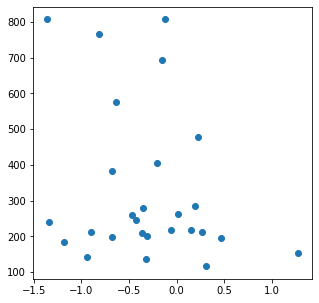

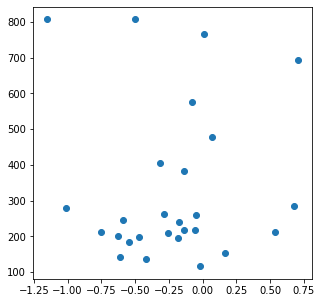

In [52]:
aendf = alldf[((alldf.cell=='aen')&
                (alldf.trigger_type=='paired')&
                (alldf.phase=='phase1'))]

plt.figure(figsize=(5,5))
plt.scatter(aendf['spkrt_post']-aendf['spkrt_base'],
            aendf['ntrials_pairing'])

r = stats.spearmanr(aendf['spkrt_post']-aendf['spkrt_base'],
                    aendf['ntrials_pairing'])
print(r)

plt.figure(figsize=(5,5))
plt.scatter(aendf['sp_change'],
            aendf['ntrials_pairing'])

r = stats.spearmanr(aendf['sp_change'],aendf['ntrials_pairing'])
print(r)

effect of condition on negative image in AENs? <br/>
note that motor command conditions sample size too small to assess this result appropriately

In [68]:
r = stats.kruskal(alldf[(alldf.condition=='aen_vent')&(alldf.cell=='aen')]['sp_change'].values,
             alldf[(alldf.condition=='aen_ventcmd')&(alldf.cell=='aen')]['sp_change'].values,
             alldf[(alldf.condition=='aen_proprio')&(alldf.cell=='aen')]['sp_change'].values,
             alldf[(alldf.condition=='aen_swimcmd')&(alldf.cell=='aen')]['sp_change'].values)
print(r)


KruskalResult(statistic=nan, pvalue=nan)


In [8]:
# functions for plotting example cell data
def anal_raw(iexpt,thisexpt_name):
    dt = 1/1000 
    ntrials_per_period = 75 

    print(iexpt,thisexpt_name)

    thisexpt = meta.loc[meta['exptname'] == thisexpt_name]

    trial_duration = thisexpt.trial_duration.values[0]
    
    basename = thisexpt_name[0:-8]
    data_folder = Path.cwd() / basename
    file_to_open = data_folder / Path(basename + '.smr')
    bl = Spike2IO(file_to_open,try_signal_grouping=False).read_block()

    trigger = []
    for sublist in np.asarray([seg.events[[s.name for 
       s in seg.events].index(thisexpt.chan_trigger.values[0])].magnitude 
       for seg in bl.segments]):
        for item in sublist:
            trigger.append(item)
    trigger = np.asarray(trigger)

    if thisexpt.spike_times_from.values[0] == 'Spyking-Circus':
        spikes = np.load(data_folder / 'spikes.npy')

    if thisexpt.spike_times_from.values[0] == 'Spike2':
        spikes = []
        for sublist in np.asarray([seg.events[[s.name for 
           s in seg.events].index(thisexpt.chan_spikes.values[0])].magnitude 
           for seg in bl.segments]):
            for item in sublist:
                spikes.append(item)
        spikes = np.asarray(spikes)

    postpairing_range = get_range_bounds([thisexpt.post_start.values[0],
                                          thisexpt.post_stop.values[0]],trigger)
    stim_range = get_range_bounds([thisexpt.stim_start.values[0],
                                   thisexpt.stim_stop.values[0]],trigger)
    base_range = get_range_bounds([thisexpt.base_start.values[0],
                                   thisexpt.base_stop.values[0]],trigger)

    if thisexpt_name == '20060812_3066_SPK.mat':
        #removing a few trials in which spike detection was clearly mis-triggered due to movement artifact
        removeinds = np.arange(360,np.max(postpairing_range)-1,1)
        [postpairing_range.remove(x) for x in removeinds]
        removeinds = [263, 264, 265, 326, 327] 
        [postpairing_range.remove(x) for x in removeinds]

    xtime = np.linspace(0,trial_duration,trial_duration/dt)

    iei = [(TrialEventTimes(trigger,trigger,trial,10))[0] if len(TrialEventTimes(trigger,trigger,trial,10))>0 else 0 for trial in list(range(0,len(trigger)-1))]

    these_trials = base_range
    y, t, optw, C, C_min= get_optw(these_trials,spikes,xtime,trigger,trial_duration)

    data_func = filtered_response(spikes, optw)

    baseline_r = get_response(trigger[these_trials],data_func,trial_duration,optw)
    baseline_mean = np.mean(baseline_r,0)

    n_trials = len(base_range)
    base_spkrt = [np.shape(np.where((spikes>(trigger[t]))&(spikes<(trigger[t]+trial_duration)))[0])[0]
                  /trial_duration for t in base_range]
    
    spikemat_base = [spikes[np.where((spikes>trigger[t])&
                    (spikes<trigger[t]+trial_duration))[0]
                    ]-(trigger[t]) for t in base_range]

    if thisexpt_name == '20071025_3335_control_SPK.mat': 
    #not enough baseline recorded so get estimate of baseline from test cell clock trigger baseline
        print('using pre pairing expt to get baseline (recovery end)')
        suppname = '20071025_3335_SPK.mat'
        suppexpt = meta.loc[meta['exptname'] == suppname]
        basename = suppname[0:-8]
        data_folder = Path.cwd() / basename
        supptrigger = np.arange(suppexpt.post_stop.values[0]-250,suppexpt.post_stop.values[0],trial_duration)
        suppbase_range = np.arange(0,len(supptrigger),1)
        base_range = suppbase_range

        suppspikes = np.load(data_folder / 'spikes.npy')

        these_trials = suppbase_range
        y, t, optw, C, C_min= get_optw(these_trials,suppspikes,xtime,supptrigger,trial_duration)
        data_func = filtered_response(suppspikes, optw)

        baseline_mean = np.mean(get_response(
            supptrigger[these_trials],data_func,trial_duration,optw),0)
        base_spkrt = [np.shape(np.where((suppspikes>(supptrigger[t]))&
                                        (suppspikes<(supptrigger[t]+trial_duration)))[0])[0]
                      /trial_duration for t in suppbase_range]
        spikemat_base = [suppspikes[np.where((suppspikes>supptrigger[t])&
                (suppspikes<supptrigger[t]+trial_duration))[0]
                ]-(supptrigger[t]) for t in suppbase_range]

    if thisexpt_name == '20071026_3108_control_SPK.mat': 
    #not enough baseline recorded so get estimate of baseline from test cell clock trigger baseline
        print('using pre pairing expt to get baseline')
        suppname = '20071026_3108_SPK.mat'
        suppexpt = meta.loc[meta['exptname'] == suppname]
        basename = suppname[0:-8]
        data_folder = Path.cwd() / basename
        file_to_open = data_folder / Path(basename + '.smr')
        bl = Spike2IO(file_to_open,try_signal_grouping=False).read_block()
        supptrigger = np.arange(0,suppexpt.base_stop.values[0],trial_duration)
        suppbase_range = np.arange(0,len(supptrigger),1)
        base_range = suppbase_range

        suppspikes = []
        for sublist in np.asarray([seg.events[[s.name for 
           s in seg.events].index(suppexpt.chan_spikes.values[0])].magnitude 
           for seg in bl.segments]):
            for item in sublist:
                suppspikes.append(item)
        suppspikes = np.asarray(suppspikes)
        
        these_trials = suppbase_range
        y, t, optw, C, C_min= get_optw(these_trials,suppspikes,xtime,supptrigger,trial_duration)
        data_func = filtered_response(suppspikes, optw)

        baseline_r = np.mean(get_response(
            supptrigger[these_trials],data_func,trial_duration,optw),0)
        
        base_spkrt = [np.shape(np.where((suppspikes>(supptrigger[t]))&
                                        (suppspikes<(supptrigger[t]+trial_duration)))[0])[0]
                      /trial_duration for t in suppbase_range]
        spikemat_base = [suppspikes[np.where((suppspikes>supptrigger[t])&
                (suppspikes<supptrigger[t]+trial_duration))[0]
                ]-(supptrigger[t]) for t in suppbase_range]

    data_func = filtered_response(spikes, optw)
    
    npair = len(stim_range)
    ntrials = np.min([npair,ntrials_per_period*2])
    stiminitial_trials = stim_range[0:int(ntrials/2)]
    these_trials = stiminitial_trials
    stimi_spkrt = [np.shape(np.where((spikes>(trigger[t]))&(spikes<(trigger[t]+trial_duration)))[0])[0]
                   /trial_duration for t in these_trials]
    y, t, optw_stim, C, C_min= get_optw(these_trials,spikes,xtime,trigger,trial_duration)
    stiminitial_r = get_response(trigger[these_trials],data_func,trial_duration,optw)
    stiminitial_response = np.mean(stiminitial_r,0)

    stimfinal_trials = stim_range[-int(ntrials/2):]
    these_trials = stimfinal_trials
    stimf_spkrt = [np.shape(np.where((spikes>(trigger[t]))&(spikes<(trigger[t]+trial_duration)))[0])[0]
                   /trial_duration for t in these_trials]
    stimfinal_r = get_response(trigger[these_trials],data_func,trial_duration,optw)
    stimfinal_response = np.mean(stimfinal_r,0)

    npost = len(postpairing_range)
    ntrials = np.min([npost,ntrials_per_period])
    postpairing_trials = postpairing_range[0:ntrials]
    these_trials = postpairing_trials
    post_spkrt = [np.shape(np.where((spikes>(trigger[t]))&(spikes<(trigger[t]+trial_duration)))[0])[0]
                  /trial_duration for t in these_trials]
    postpairing_r = get_response(trigger[these_trials],data_func,trial_duration,optw)
    postpairing_response = np.mean(postpairing_r,0)

    recovery_spkrt = np.nan
    recovery_response = np.empty(len(baseline_mean))
    if npost>=250:
        recovery_trials = postpairing_range[200:250]
        recovery_spkrt = [np.shape(np.where((spikes>(trigger[t]))&(spikes<(trigger[t]+trial_duration)))[0])[0]
                          /trial_duration for t in recovery_trials]
        these_trials = recovery_trials
        recovery_r = get_response(trigger[these_trials],data_func,trial_duration,optw)
        recovery_response = np.mean(recovery_r,0)
        

    spikemat_stim = [spikes[np.where((spikes>trigger[t])&
                    (spikes<trigger[t]+trial_duration))[0]
                    ]-(trigger[t]) for t in stim_range]
    spikemat_post = [spikes[np.where((spikes>trigger[t])&
                    (spikes<trigger[t]+trial_duration))[0]
                    ]-(trigger[t]) for t in postpairing_range]
    
    return (spikemat_base, spikemat_stim, spikemat_post, 
            np.mean(baseline_r,0), np.mean(stiminitial_r,0), 
            np.mean(stimfinal_r,0), np.mean(postpairing_r,0), recovery_response,
           trial_duration)

def doplots(exptname,scale_raster,ylims,spkbase, spkstim, spkpost,base, stimi, stimf,post,recover,trial_duration):
    allspks = np.concatenate([spkbase,spkstim,spkpost])
    hfig1 = plt.figure(figsize=(3,len(allspks)/scale_raster))
    for i,trial in enumerate(allspks):
        for s in trial:
            plt.scatter(s,i,color='black',marker='|',s=10)
    plt.plot([0,trial_duration],[len(spkbase),len(spkbase)],color='black',lw=2)
    plt.plot([0,trial_duration],[len(spkbase)+len(spkstim),
                                 len(spkbase)+len(spkstim)],color='black',lw=2)
    plt.xlim(0,trial_duration)
    plt.ylim(len(allspks),0)
    plt.savefig('Figures/revisions/raster_' + exptname + '_.eps', format='eps', dpi=1000)

    hfig2 = plt.figure(figsize=(3,4))
    plt.plot(xtime,base,color='black')
    plt.plot(xtime,stimi,color='green')
    plt.plot(xtime,stimf,color=sns.xkcd_rgb['bright green'])
    plt.plot(xtime,post,color=sns.xkcd_rgb['bright purple'])
    plt.ylim(ylims[0],ylims[1])
    plt.savefig('Figures/revisions/responseAvg_' + exptname + '_.eps', format='eps', dpi=1000)

    hfig3 = plt.figure(figsize=(3,4))
    plt.plot([0,trial_duration],[0,0],color='black')
    plt.plot(xtime,stimi-base,color='green')
    plt.plot(xtime,stimf-base,color=sns.xkcd_rgb['bright green'])
    plt.plot(xtime,post-base,color=sns.xkcd_rgb['bright purple'])
    plt.ylim(ylims[0],ylims[1])
    plt.savefig('Figures/revisions/responseAvgBaseSub_' + exptname + '_.eps', format='eps', dpi=1000)
    
    

In [13]:
meta = pd.read_csv('MetaData.csv')

0               20050727_3224_SPK.mat
1      20050728_3404_latency1_SPK.mat
2      20050728_3404_latency2_SPK.mat
3      20050808_3629_latency1_SPK.mat
4      20050808_3629_latency2_SPK.mat
5               20050811_3221_SPK.mat
6               20050818_2874_SPK.mat
7               20050819_2601_SPK.mat
8        20050820_2960_trial1_SPK.mat
9       20050824_2627_control_SPK.mat
10       20050824_2627_trial1_SPK.mat
11              20060626_2815_SPK.mat
12              20060627_2673_SPK.mat
13              20060708_3004_SPK.mat
14              20060710_2767_SPK.mat
15              20060710_3196_SPK.mat
16              20060804_2107_SPK.mat
17              20060812_2921_SPK.mat
18              20060812_3066_SPK.mat
19              20060812_3205_SPK.mat
20              20060816_3893_SPK.mat
21       20070718_598_coupled_SPK.mat
22        20070719_91_coupled_SPK.mat
23              20070720_3352_SPK.mat
24               20070723_287_SPK.mat
25               20070723_311_SPK.mat
26          

49 20070801_3838_SPK.mat


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


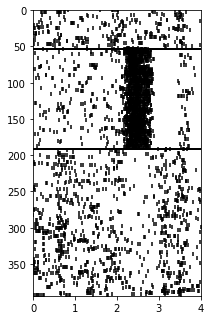

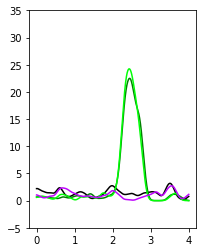

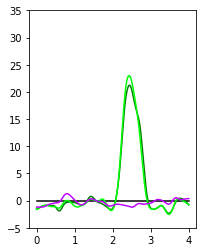

In [14]:
iexpt = 49
scalefig = 75
dt = 1/1000
spkbase, spkstim, spkpost,base, stimi, stimf,post,recover,trial_duration  = anal_raw(iexpt,meta.exptname[iexpt])
xtime = np.linspace(0,trial_duration,trial_duration/dt)
ylims = [-5,35]
doplots(meta.exptname[iexpt],scalefig,ylims,spkbase, spkstim, 
        spkpost,base, stimi, stimf,post,recover,trial_duration)

9 20050824_2627_control_SPK.mat


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


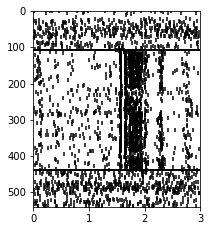

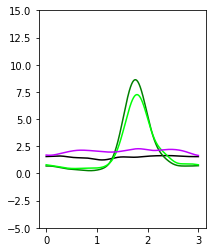

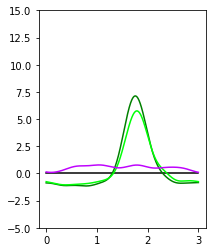

In [17]:
iexpt = 9
scalefig = 150
dt = 1/1000
spkbase, spkstim, spkpost,base, stimi, stimf,post,recover,trial_duration  = anal_raw(iexpt,meta.exptname[iexpt])
xtime = np.linspace(0,trial_duration,trial_duration/dt)
ylims = [-5,15]
doplots(meta.exptname[iexpt],scalefig,ylims,spkbase, spkstim, 
        spkpost,base, stimi, stimf,post,recover,trial_duration)


10 20050824_2627_trial1_SPK.mat


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


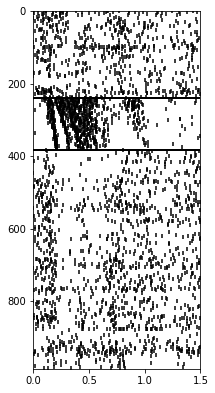

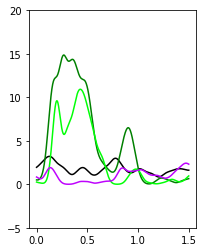

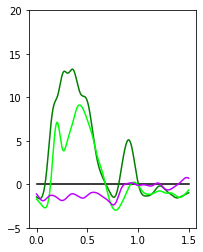

In [18]:
iexpt = 10
scalefig = 150
dt = 1/1000
spkbase, spkstim, spkpost,base, stimi, stimf,post,recover,trial_duration  = anal_raw(iexpt,meta.exptname[iexpt])
xtime = np.linspace(0,trial_duration,trial_duration/dt)
ylims = [-5,20]
doplots(meta.exptname[iexpt],scalefig,ylims,spkbase, spkstim, 
        spkpost,base, stimi, stimf,post,recover,trial_duration)


21 20070718_598_coupled_SPK.mat


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


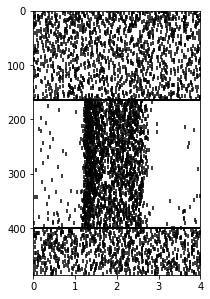

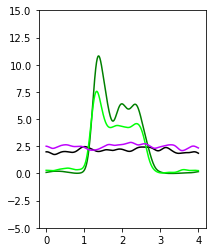

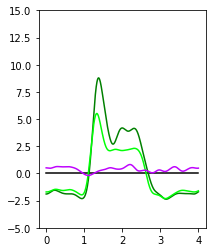

In [19]:
iexpt = 21
scalefig = 100
dt = 1/1000
spkbase, spkstim, spkpost,base, stimi, stimf,post,recover,trial_duration  = anal_raw(iexpt,meta.exptname[iexpt])
xtime = np.linspace(0,trial_duration,trial_duration/dt)
ylims = [-5,15]
doplots(meta.exptname[iexpt],scalefig,ylims,spkbase, spkstim, 
        spkpost,base, stimi, stimf,post,recover,trial_duration)


4 20050808_3629_latency2_SPK.mat


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


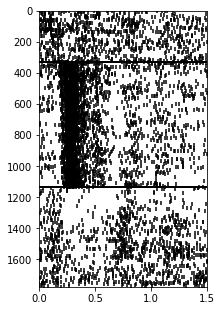

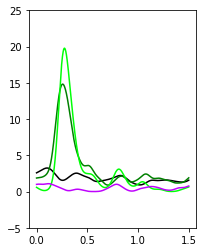

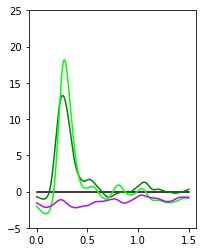

In [20]:
iexpt = 4
scalefig = 350
dt = 1/1000
spkbase, spkstim, spkpost,base, stimi, stimf,post,recover,trial_duration  = anal_raw(iexpt,meta.exptname[iexpt])
xtime = np.linspace(0,trial_duration,trial_duration/dt)
ylims = [-5,25]
doplots(meta.exptname[iexpt],scalefig,ylims,spkbase, spkstim, 
        spkpost,base, stimi, stimf,post,recover,trial_duration)


3 20050808_3629_latency1_SPK.mat


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


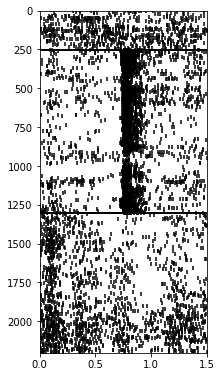

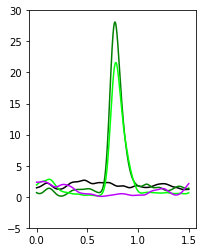

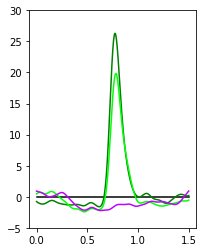

In [21]:
iexpt = 3
scalefig = 350
dt = 1/1000
spkbase, spkstim, spkpost,base, stimi, stimf,post,recover,trial_duration  = anal_raw(iexpt,meta.exptname[iexpt])
xtime = np.linspace(0,trial_duration,trial_duration/dt)
ylims = [-5,30]
doplots(meta.exptname[iexpt],scalefig,ylims,spkbase, spkstim, 
        spkpost,base, stimi, stimf,post,recover,trial_duration)


48 20050808_3629_latency1b_SPK.mat


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


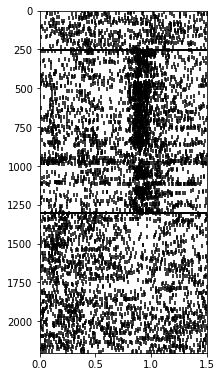

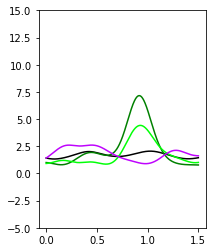

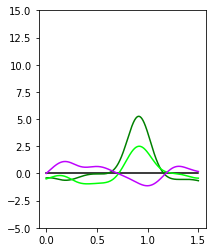

In [22]:
iexpt = 48
scalefig = 350
dt = 1/1000
spkbase, spkstim, spkpost,base, stimi, stimf,post,recover,trial_duration  = anal_raw(iexpt,meta.exptname[iexpt])
xtime = np.linspace(0,trial_duration,trial_duration/dt)
ylims = [-5,15]
doplots(meta.exptname[iexpt],scalefig,ylims,spkbase, spkstim, 
        spkpost,base, stimi, stimf,post,recover,trial_duration)


47 20050808_3629_latency2b_SPK.mat


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


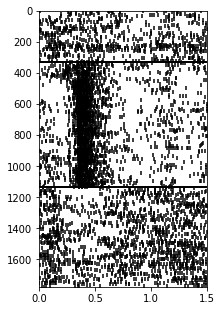

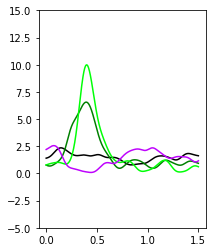

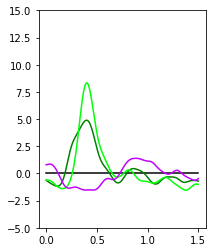

In [23]:
iexpt = 47
scalefig = 350
dt = 1/1000
spkbase, spkstim, spkpost,base, stimi, stimf,post,recover,trial_duration  = anal_raw(iexpt,meta.exptname[iexpt])
xtime = np.linspace(0,trial_duration,trial_duration/dt)
ylims = [-5,15]
doplots(meta.exptname[iexpt],scalefig,ylims,spkbase, spkstim, 
        spkpost,base, stimi, stimf,post,recover,trial_duration)
